In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import json

import jax

jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn

import arviz as az
import arviz.labels as azl
import pandas as pd

import einops
import os

from tensorflow_probability.substrates import jax as tfp
tfd =  tfp.distributions
tfb = tfp.bijectors

key = jr.PRNGKey(0)

import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.33,5.5)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette('colorblind')

In [2]:
mec_type = 'phi'
#mec_type = 'G'
if mec_type == 'G':
    naming = '|G^*|'
    units = 'Pa'
else:
    naming = '\Phi'
    units = 'rad'

xlabel = 'Crosslinker concentration [mM]'

In [3]:
path = 'data'

In [4]:
data = pd.read_csv(os.path.join(path,'processed_both.csv'),index_col=0)
data['concentration'] = 2.0
data['temp'] = 37.
data3 = pd.read_csv(os.path.join(path,'new_37_low.csv'),index_col=0)
data3['concentration'] = 1.0
data3['temp'] = 37.
data4 = pd.read_csv(os.path.join(path,'new_37_high.csv'),index_col=0)
data4['concentration'] = 3.0
data4['temp'] = 37.
data5 = pd.read_csv(os.path.join(path,'new_20_high.csv'),index_col=0)
data5['concentration'] = 2.0
data5['temp'] = 20.
data = pd.concat([data,data3,data4,data5])
data = data[data['phi_(rad)']>np.deg2rad(0)]
data = data.groupby(['temp','concentration','type','coating_type','size','crosslinker','day',
                     'day_repeat','sample','holder','location','track_id']).mean(numeric_only=True).reset_index(drop=False)
data = data.dropna()
data_raw = data.copy()
a_mask = (np.array(data['a_(um)'])*1e3)>1
print(np.sum(a_mask)/a_mask.shape[0])
data = data[a_mask]
#data['G_abs'] = np.log(data['G_abs'])
data['pre'] = 'mean'
data.shape

1.0


(1013, 35)

In [5]:
macro = pd.read_csv(os.path.join(path,'processed_macro.csv'),index_col=0)

In [6]:
def index_macro(name):
    radius_indices = np.zeros(macro.shape[0],dtype=int)
    radius_orig = np.zeros(macro.shape[0],dtype=object)
    for idx,i in enumerate(np.unique(macro[name])):
        mask = macro[name]==i
        radius_indices[mask] = idx
        radius_orig[mask] = i
    return radius_indices,radius_orig



macro_type_indices,macro_type_orig = index_macro('type')
macro_cross_indices,macro_cross_orig = index_macro('crosslinker')


In [7]:
data['method'] = 'microrheometer'#'micromanipulator'
macro['method'] = 'rheometer'

In [8]:
df_both = pd.concat([data[['type','method','crosslinker','G_abs','phi_(deg)']],
                     macro[['type','method','crosslinker','Complex Shear Modulus','Phase Shift Angle']].rename(columns={"Complex Shear Modulus": "G_abs", "Phase Shift Angle": "phi_(deg)"})])
df_both['phi_(deg)'] = np.deg2rad(df_both['phi_(deg)'])
df_both = df_both.rename(columns={'phi_(deg)':'phi_(rad)'})

In [9]:
def index(name):
    radius_indices = np.zeros(data.shape[0],dtype=int)
    radius_orig = np.zeros(data.shape[0],dtype=object)
    for idx,i in enumerate(np.unique(data[name])):
        mask = data[name]==i
        radius_indices[mask] = idx
        radius_orig[mask] = i
    return radius_indices,radius_orig

radius_indices,radius_orig = index('size')
type_indices,type_orig = index('type')
coating_indices,coating_orig = index('coating_type')
cross_indices,_ = index('crosslinker')


In [10]:
for i,j in data.groupby(['type','coating_type','size']):
    print(i,j.shape)

('alginate', 'COOH', 30.0) (50, 36)
('alginate', 'COOH', 50.0) (51, 36)
('alginate', 'COOH', 100.0) (41, 36)
('alginate', 'NH2', 30.0) (42, 36)
('alginate', 'NH2', 50.0) (54, 36)
('alginate', 'NH2', 100.0) (43, 36)
('alginate', 'plain', 10.0) (201, 36)
('alginate', 'plain', 30.0) (66, 36)
('alginate', 'plain', 50.0) (40, 36)
('alginate', 'plain', 100.0) (35, 36)
('ipn', 'NH2', 30.0) (33, 36)
('ipn', 'NH2', 100.0) (19, 36)
('ipn', 'plain', 30.0) (325, 36)
('ipn', 'plain', 100.0) (13, 36)


In [11]:
crosslinker = jnp.array(data['crosslinker'])
crosslinker_raw = crosslinker.copy()
c_mean = crosslinker.mean()
c_std = crosslinker.std()
crosslinker = (crosslinker-c_mean)/c_std
fig = plt.figure(figsize=(9,4))
if mec_type=='G':
    G = jnp.array(data['G_abs'])
else:
    G = jnp.array(data['phi_(rad)'])
G_raw = G.copy()
if mec_type!='G_':
    G = jnp.log(G)
#G = jnp.sqrt(G)
g_mean = G.mean()
g_std = G.std()
#G -= g_mean
G = (G-g_mean)/g_std



#plt.xlabel(r'${}$'.format(naming))
df = pd.DataFrame({'crosslinker':crosslinker,'G':G,'radius':radius_indices,'type':type_indices,'coating':coating_indices})

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

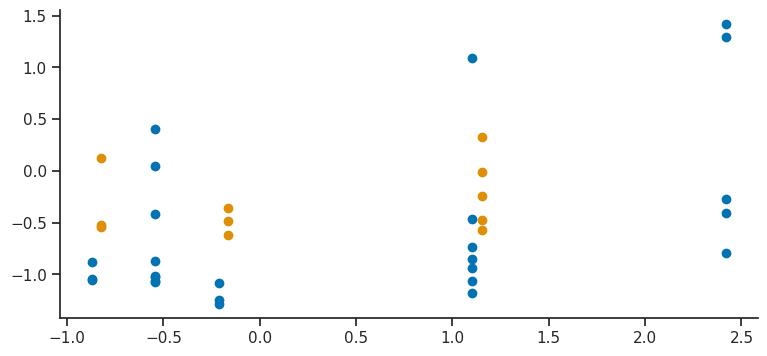

In [12]:
crosslinker_macro = jnp.array(macro['crosslinker'])
crosslinker_macro_raw = crosslinker_macro.copy()

crosslinker_macro = (crosslinker_macro-c_mean)/c_std
fig = plt.figure(figsize=(9,4))
if mec_type=='G':
    G_macro = jnp.array(macro['Complex Shear Modulus'])
else:
    G_macro = jnp.array(np.deg2rad(macro['Phase Shift Angle'].values))
G_raw_macro = G_macro.copy()
if mec_type!='G_':
    G_macro = jnp.log(G_macro)

#G -= g_mean
G_macro = (G_macro-g_mean)/g_std

fig = plt.figure(figsize=(9,4))
for i in jnp.unique(macro_type_indices):
    mask = macro_type_indices==i
    plt.scatter(crosslinker_macro[mask]+0.05*i,G_macro[mask])

df = pd.DataFrame({'crosslinker':crosslinker_macro,'G':G_macro,'type':macro_type_orig})

In [13]:
cross_unique = np.unique(crosslinker)
cross_unique_alg = np.unique(crosslinker[type_indices==0])
cross_unique_ipn = np.unique(crosslinker[type_indices==1])
N_alg = len(cross_unique_alg)
N_ipn = len(cross_unique_ipn)
indices = np.ones_like(crosslinker)
for idx,i in enumerate(cross_unique):
    indices[crosslinker==i] = idx
indices = jnp.array(indices).astype(int)


In [14]:
cross_unique_macro = np.unique(crosslinker_macro)
cross_unique_macro_alg = np.unique(crosslinker_macro[macro_type_indices==0])
cross_unique_macro_ipn = np.unique(crosslinker_macro[macro_type_indices==1])
N_macro = len(cross_unique_macro)

N_macro_alg = len(cross_unique_macro_alg)
N_macro_ipn = len(cross_unique_macro_ipn)

indices_macro = np.ones_like(crosslinker_macro)
for idx,i in enumerate(cross_unique_macro):
    indices_macro[crosslinker_macro==i] = idx
indices_macro = jnp.array(indices_macro).astype(int)

In [15]:
N = N_alg + N_ipn + N_macro_alg + N_macro_ipn 

In [16]:
print(cross_unique_alg)
print(cross_unique_ipn)
print(cross_unique_macro)

[-0.8719907  -0.54288244 -0.21377422  1.1026587   2.4190917 ]
[-0.8719907  -0.21377422  1.1026587 ]
[-0.8719907  -0.54288244 -0.21377422  1.1026587   2.4190917 ]


In [17]:
micro_coords = jnp.arange(N_alg+N_ipn,dtype=int)
macro_coords = jnp.arange(N_alg+N_ipn,N,dtype=int)

In [18]:
def rbf(x,alpha,rho):
    diff = x[None,...]-x[:,None,:]
    dist = jnp.linalg.norm(diff,axis=-1)**2
    cov = alpha**2*jnp.exp(-dist/(2*rho**2))
    return cov[...,None]

In [19]:
indices_typed = np.copy(indices+type_indices*N_alg)
for idx,i in enumerate(np.unique(indices_typed)):
    indices_typed[indices_typed==i] = idx
indices_typed = jnp.array(indices_typed)

In [20]:
indices_typed_macro = np.copy(indices_macro+macro_type_indices*N_macro_alg)
for idx,i in enumerate(np.unique(indices_typed_macro)):
    indices_typed_macro[indices_typed_macro==i] = idx
indices_typed_macro = jnp.array(indices_typed_macro)

In [21]:
N_radius = np.unique(radius_indices).shape[0]
N_radius

N_coating = np.unique(coating_indices).shape[0]
N_coating

3

In [22]:
N_micro = N_alg+N_ipn
N_macro = N_macro_alg+N_macro_ipn

In [23]:
micro_alg_indices = (type_indices==0).astype(int)
micro_ipn_indices = (type_indices==1).astype(int)
micro_mu_indices = (micro_alg_indices+micro_ipn_indices*2)-1
micro_mu_indices.shape

(1013,)

In [24]:
macro_alg_indices = (macro_type_indices==0).astype(int)
macro_ipn_indices = (macro_type_indices==1).astype(int)
macro_mu_indices = (macro_alg_indices+macro_ipn_indices*2)+1
macro_mu_indices.shape

(37,)

In [40]:
def gen_indices(data,names,idx,indices,orig_indices):
    # generate running indices based on the hierarchy
    
    # break recursion if at the end of hierarchy
    if idx>=len(names):
        return indices,orig_indices
    for ii,i in data.groupby(names[idx]):
        counts = i.shape[0]
        latest = 1
        l = indices[names[idx]]
        if len(l) != 0:
            latest = l[-1]+1
        # add running indices to the current level hierarchy
        indices[names[idx]].extend([latest]*counts)
        orig_indices[names[idx]].extend([ii]*counts)
        indices,orig_indices = gen_indices(i,names,idx+1,indices,orig_indices)
    return indices,orig_indices

gnames = ['temp','concentration','type','coating_type','size','crosslinker','day','day_repeat','sample','holder','location']
g_indices = {i:[] for i in gnames}
g_orig_indices = {i:[] for i in gnames}

gindices,gorig_indices = gen_indices(data,gnames,0,g_indices,g_orig_indices)

type_indices = jnp.array(gindices['type'])-1
temp_indices = jnp.array(gindices['temp'])-1
concentration_indices = jnp.array(gindices['concentration'])-1
sample_indices = jnp.array(gindices['sample'])-1
holder_indices = jnp.array(gindices['holder'])-1

N_dat_samples = np.max(gindices['sample'])
N_holders = np.max(gindices['holder'])

In [26]:
cross_all = jnp.concatenate([cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,cross_unique_macro_ipn])
concentration = np.array(data['concentration'].values)
concentration = jnp.array((concentration-concentration.mean())/concentration.std())
temperature = np.array(data['temp'].values)
temperature = jnp.array((temperature-temperature.min())/(temperature.max()-temperature.std()))

In [61]:
types = np.zeros_like(data['type'].values,dtype=float)
for i in data['type'].unique():
    if i=='ipn':
        types[data['type'].values==i] = 1
types = jnp.array(types)

In [62]:
sigmoid = lambda x,sat: 1/(1+jnp.exp(-sat*x))

@tfd.JointDistributionCoroutineAutoBatched
def model():

    slope1 = yield tfd.Sample(tfd.Normal(0.,1.),(1,4),name='slope1')
    intercept = yield tfd.Sample(tfd.Normal(0.,1.),(1,4),name='intercept')

    
    sigma_alpha = yield tfd.Sample(tfd.HalfNormal(1),(4,),name='sigma_alpha')
    sigma_rho = yield tfd.Sample(tfd.InverseGaussian(1.,3.),(4,),name='sigma_rho')
    sigma_eta = yield tfd.Sample(tfd.Normal(0.,1.),(N,),name='sigma_eta')

    #coating_mu = yield tfd.Normal(0,1,name='coating_mu')
    coating_std = yield tfd.HalfNormal(1,name='coating_std')
    coating_z = yield tfd.Normal([0]*N_coating,1,name='coating_z')
    coating_effects = jnp.ones_like(crosslinker)*(coating_std*coating_z[coating_indices])

    # concentration
    concentration_mean = yield tfd.Normal(0,1,name='concentration_mu')
    concentration_intercept = yield tfd.Normal(0,1,name='concentration_intercept')
    concentration_effect = concentration_mean*concentration+concentration_intercept

    # temperature
    temperature_mean = yield tfd.Normal(0,1,name='temperature_mu')
    temperature_intercept = yield tfd.Normal(0,1,name='temperature_intercept')
    temperature_effect = temperature_mean*temperature+temperature_intercept

    holder_std = yield tfd.HalfNormal(1.,name='holder_std')
    sample_std = yield tfd.HalfNormal(1.,name='sample_std')
    holder_z = yield tfd.Normal([0]*N_holders,1,name='holder_z')
    sample_z = yield tfd.Normal([0]*N_dat_samples,1,name='sample_z')
    #coating_sigma_std = yield tfd.HalfNormal(1,name='coating_sigma_std')
    #coating_sigma_z = yield tfd.Normal([0]*N_coating,1,name='coating_sigma_z')
    #coating_sigma_effects = jnp.ones_like(crosslinker)*(coating_sigma_std*coating_sigma_z[coating_indices])
    holder_effect = jnp.ones_like(crosslinker)*(holder_std*holder_z[holder_indices])
    sample_effect = jnp.ones_like(crosslinker)*(sample_std*sample_z[sample_indices])
    #mean_mu = yield tfd.Sample(tfd.Normal(0,1),(4,),name='mean_mu')
    sigma_mu = yield tfd.Sample(tfd.Normal(0,1),(4,),name='sigma_mu')
    #radius_mu = yield tfd.Normal(0,1,name='radius_mu')
    radius_std = yield tfd.HalfNormal(1,name='radius_std')
    radius_z = yield tfd.Normal([0]*N_radius,1,name='radius_z')
    radius_effects = jnp.ones_like(crosslinker)*(radius_std*radius_z[radius_indices])

    #radius_sigma_mu = yield tfd.Normal(0,1,name='radius_sigma_mu')
    radius_sigma_std = yield tfd.HalfNormal(1,name='radius_sigma_std')
    radius_sigma_z = yield tfd.Normal([0]*N_radius,1,name='radius_sigma_z')
    radius_sigma_effects = jnp.ones_like(crosslinker)*(radius_sigma_std*radius_sigma_z[radius_indices])
    
    K_sigma = jax.scipy.linalg.block_diag(
        rbf(cross_unique_alg[...,None],sigma_alpha[0],sigma_rho[0])[...,0],
        rbf(cross_unique_ipn[...,None],sigma_alpha[1],sigma_rho[1])[...,0],
        rbf(cross_unique_macro_alg[...,None],sigma_alpha[2],sigma_rho[2])[...,0],
        rbf(cross_unique_macro_ipn[...,None],sigma_alpha[3],sigma_rho[3])[...,0])+jnp.eye(N)*(1e-5)
    L_K_sigma = jnp.linalg.cholesky(K_sigma)

    curve = slope1*cross_all[...,None]+intercept
    sigma = L_K_sigma@sigma_eta
    
    lik = yield tfd.Normal(loc=curve[micro_coords][indices_typed,micro_mu_indices]+radius_effects+coating_effects+holder_effect+sample_effect+\
                                    concentration_effect*types+temperature_effect*types,
                                   scale=jnn.softplus(sigma[micro_coords][indices_typed]+sigma_mu[micro_mu_indices]+radius_sigma_effects),
                                   name='likelihood')
    lik_mac = yield tfd.Normal(loc=curve[macro_coords][indices_typed_macro,macro_mu_indices],
                               scale=jnn.softplus(sigma[macro_coords][indices_typed_macro]+sigma_mu[macro_mu_indices]),name='likelihood_macro')

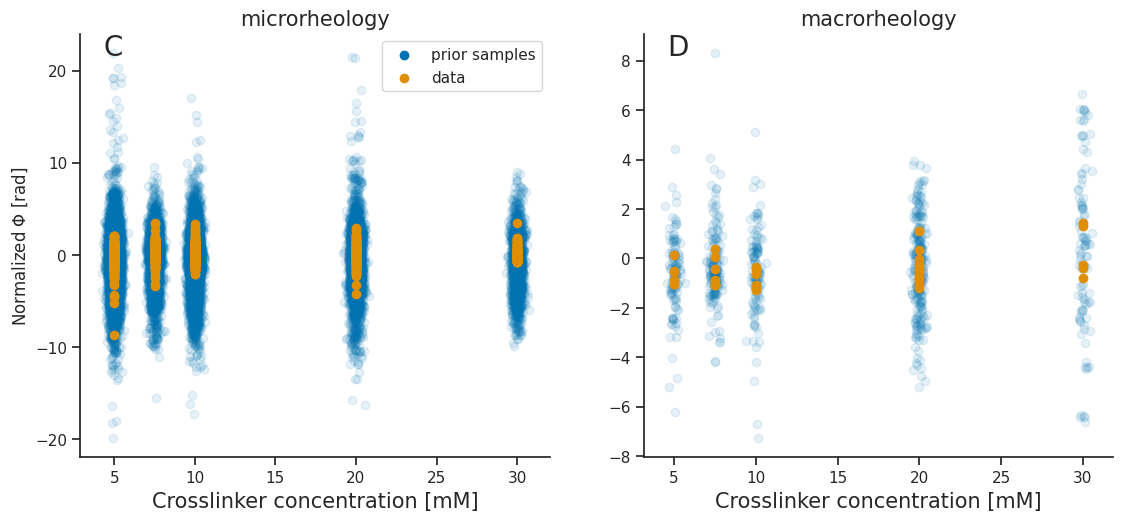

In [63]:
target = model.experimental_pin(likelihood=G,likelihood_macro=G_macro)
bijector = target.experimental_default_event_space_bijector()
n_prior = 20
init_samples = model.sample(n_prior,seed=key)

fig,ax = plt.subplots(1,2)


N_pred = 100
c_pred = jnp.linspace(crosslinker.min(),crosslinker.max(),N_pred)


states_prior = model.sample((n_prior,1),seed=key)
num_c = states_prior.sigma_alpha.shape[1]
sub_sample = 1

slope = states_prior.slope1[::sub_sample,:][...,None]
intercept = states_prior.intercept[::sub_sample,:][...,None]

curve = slope*c_pred[None,None,None,...]+intercept
tt1 = jnp.squeeze(curve[:,0])[:,0,:]


for i in range(n_prior):
    #ax[0].plot(c_pred*c_std+c_mean,tt1[i],color=sns.color_palette('colorblind')[0],zorder=0,alpha=0.2)
    l1 = ax[0].scatter(crosslinker_raw+np.random.normal(0,0.2,crosslinker.shape[0]),
                  init_samples.likelihood[i],alpha=0.1,color=sns.color_palette('colorblind')[0])
l2 = ax[0].scatter(crosslinker_raw,G,color=sns.color_palette('colorblind')[1])
ax[0].scatter(np.NaN,np.NaN,color=sns.color_palette('colorblind')[0],label='prior samples')
ax[0].scatter(np.NaN,np.NaN,color=sns.color_palette('colorblind')[1],label='data')
ax[0].legend()

for i in range(n_prior):
    l1 = ax[1].scatter(crosslinker_macro_raw+np.random.normal(0,0.2,crosslinker_macro.shape[0]),
                  init_samples.likelihood_macro[i],alpha=0.1,color=sns.color_palette('colorblind')[0])
l2 = ax[1].scatter(crosslinker_macro_raw,G_macro,color=sns.color_palette('colorblind')[1])

ax[0].set_title('microrheology',fontsize=15)
ax[1].set_title('macrorheology',fontsize=15)
if mec_type == 'G':
    ax[0].set_ylabel(r'Normalized |G$^*$| [{}]'.format(units),fontsize=15)
    #fig.suptitle(r'Prior predictive for |G$^*$|')
else:
    ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units))
    #fig.suptitle(r'Prior predictive for ${}$'.format(naming))
ax[1].set_ylabel('')
ax[0].set_xlabel(xlabel,fontsize=15)
ax[1].set_xlabel(xlabel,fontsize=15)

ax[0].text(0.05, 0.95, 'C', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'D', transform=ax[1].transAxes,fontsize=20)
ax[0].set_xlabel(xlabel,fontsize=15)
ax[1].set_xlabel(xlabel,fontsize=15)

fig.savefig(f'results/prior_predictive_{mec_type}.png',bbox_inches = 'tight',dpi=300)

In [64]:
init_samples = model.sample(seed=key)

In [65]:
num_chains = 4
num_leapfrog_steps = 10
num_steps= 5000#20000
num_adaptation = 1000#7000
step_size = 1.

step_sizes = [jnp.ones((num_chains,*i.shape))*step_size for i in init_samples[:-2]]

@jax.jit
def run_chain2(key, state):

    hmc = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target.unnormalized_log_prob,
        step_size=step_sizes)

    hmc = tfp.mcmc.TransformedTransitionKernel(
        hmc, bijector)
    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        hmc,
        num_adaptation_steps=int(num_adaptation),
        target_accept_prob=0.9,
        reduce_fn=tfp.math.reduce_log_harmonic_mean_exp)

    return tfp.mcmc.sample_chain(num_steps,
      current_state=state,
      kernel=hmc,
      trace_fn=lambda _, results: results.inner_results.inner_results,
      seed=key)

@jax.jit
def run_chain(key, state):

    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target.unnormalized_log_prob,
        step_size=step_sizes,num_leapfrog_steps=num_leapfrog_steps)

    hmc = tfp.mcmc.TransformedTransitionKernel(
        hmc, bijector)
    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        hmc,
        num_adaptation_steps=int(num_adaptation),
        target_accept_prob=0.9,
        reduce_fn=tfp.math.reduce_log_harmonic_mean_exp)

    return tfp.mcmc.sample_chain(num_steps,
      current_state=state,
      kernel=hmc,
      trace_fn=lambda _, results: results.inner_results.inner_results.accepted_results,
      seed=key)


#states_, log_probs_ = run_chain(key,bijector.forward(list(model.sample(num_chains,seed=jr.split(key)[0])[:-1])))
states_, log_probs_ = run_chain2(key,jax.tree_map(lambda x: jnp.ones_like(x),model.sample(num_chains,seed=jr.split(key)[0])[:-2]))
states = jax.tree_map(lambda x: x[num_adaptation:,:],states_)

In [66]:
states = jax.tree_map(lambda x: jnp.squeeze(x),states)

66.69375 0.03125 33.275
49.5 3.7250001 46.775
91.23125 0.36875 8.4
48.756252 7.925 43.31875


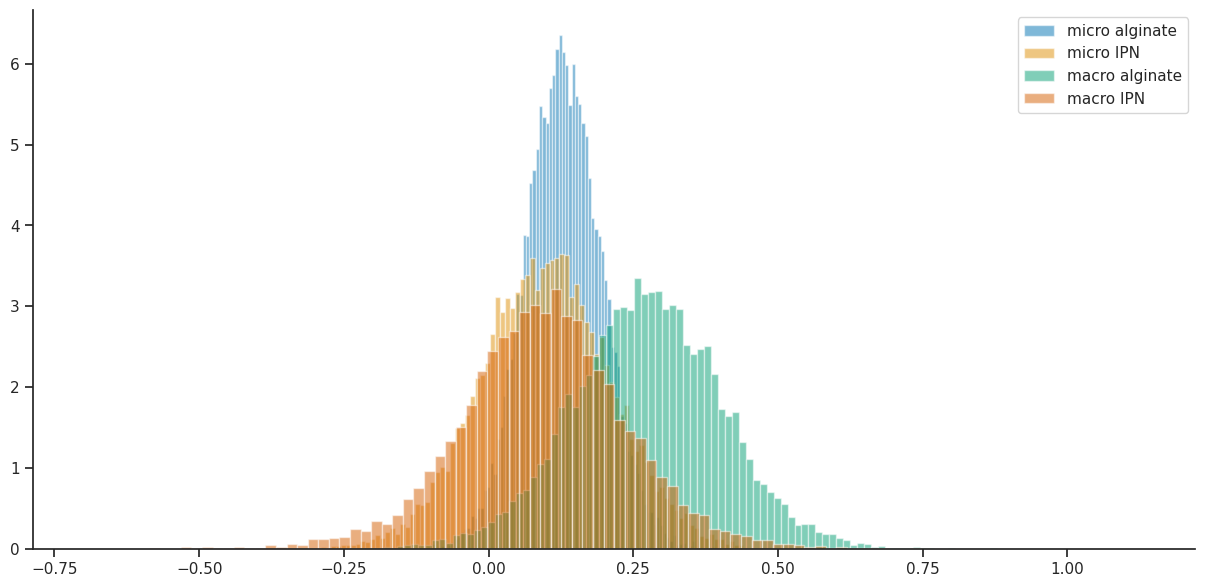

In [67]:
names = ['micro alginate','micro IPN','macro alginate','macro IPN']
ee = einops.rearrange(states.slope1, 'i j l -> (i j) l')
fig = plt.figure(figsize=(15,7))
for i,j in zip(range(ee.shape[-1]),names):
    print(np.sum(ee[:,i]>0.1)/ee[:,i].shape[0]*100,np.sum(ee[:,i]<-0.1)/ee[:,i].shape[0]*100,np.sum(np.logical_and(ee[:,i]>-0.1,ee[:,i]<0.1))/ee[:,i].shape[0]*100)
    _ = plt.hist(ee[:,i],bins=100,alpha=0.5,label=j,density=True)
_ = plt.legend()

In [68]:
log_probs = jax.tree_map(lambda x: x[num_adaptation:,:],log_probs_)

In [69]:
jax.tree_map(lambda x: (x>1.1).sum().tolist(),tfp.mcmc.potential_scale_reduction(states))

StructTuple(
  slope1=0,
  intercept=0,
  sigma_alpha=0,
  sigma_rho=0,
  sigma_eta=0,
  coating_std=0,
  coating_z=0,
  concentration_mu=0,
  concentration_intercept=0,
  temperature_mu=0,
  temperature_intercept=0,
  holder_std=0,
  sample_std=0,
  holder_z=0,
  sample_z=0,
  sigma_mu=0,
  radius_std=0,
  radius_z=0,
  radius_sigma_std=0,
  radius_sigma_z=0
)

In [70]:
def gen_samples(params):
  dists, samps = model.sample_distributions(seed=jr.PRNGKey(0),
                                       value=params + (None,))
  return samps
  
samps = jax.vmap(jax.vmap(gen_samples))(states)

def gen_dists(params,G):
  dists, samps = model.sample_distributions(seed=jr.PRNGKey(0),
                                       value=params + (None,))
  return dists[-2].prob(G)
  
dists = jax.vmap(jax.vmap(gen_dists,in_axes=(0,None)),in_axes=(0,None))(states,G[:10][...,None]).mean(axis=2)

Save these to generate the effect plot in switchpoint.ipyb

In [71]:
np.savez(os.path.join(path,'linear_states.npz'),data=dict(states._asdict()))
np.savez(os.path.join(path,'linear_log_probs.npz'),data=dict(log_probs._asdict()))
np.savez(os.path.join(path,'linear_samps.npz'),data=dict(samps._asdict()))

In [72]:
coords = {
    'radius': np.unique(radius_orig),
    'coating': np.unique(coating_orig),
    #'names': ['micro_alg','micro_ipn','macro_alg','macro_ipn']
    'names': ['micro alginate','micro IPN','macro alginate','macro IPN']
}

dims = {
    'slope1': ['names'],
    'intecept':['names'],
    #'eta':
    'sigma_alpha': ['names'],
    'sigma_rho': ['names'],
    #'mean_mu':['names'],
    'sigma_mu':['names'],
    #'sigma_eta': 
    #'coating_std': ['dim'],
    'coating_z': ['coating'],
    #'coating_sigma_z': ['coating'],
    #'radius_std': ['dim'],
    'radius_z': ['radius'],
    #'radius_sigma_std': ['dim'],
    'radius_sigma_z': ['radius'],
}

trace = az.from_dict(
    posterior=jax.tree_map(lambda x: jnp.swapaxes(x,0,1),states._asdict()),
    posterior_predictive=jax.tree_map(lambda x: jnp.swapaxes(x,0,1),samps._asdict()),
    #prior=jax.tree_map(lambda x: x[None,...],init_samples._asdict()),
    observed_data={'likelihood':G,'likelihood_macro':G_macro},
    #sample_stats={'log_likelihood':jnp.swapaxes(log_probs_.target_log_prob,0,1)},
    sample_stats={'log_likelihood':jnp.swapaxes(log_probs.target_log_prob,0,1),
                  'energy':jnp.swapaxes(log_probs.energy,0,1),
                  'diverging':jnp.swapaxes(log_probs.has_divergence,0,1)},
    coords=coords,
    dims=dims
)
trace.posterior['radius_effect'] = trace.posterior['radius_z']*trace.posterior['radius_std']
trace.posterior['radius_sigma_effect'] = trace.posterior['radius_sigma_z']*trace.posterior['radius_sigma_std']
trace.posterior['coating_effect'] = trace.posterior['coating_z']*trace.posterior['coating_std']
trace.posterior['holder_effect'] = trace.posterior['holder_z']*trace.posterior['holder_std']#+trace.posterior['holder_mu']
trace.posterior['sample_effect'] = trace.posterior['sample_z']*trace.posterior['sample_std']#+trace.posterior['sample_mu']
#trace.posterior['coating_sigma_effect'] = trace.posterior['coating_sigma_z']*trace.posterior['coating_sigma_std']

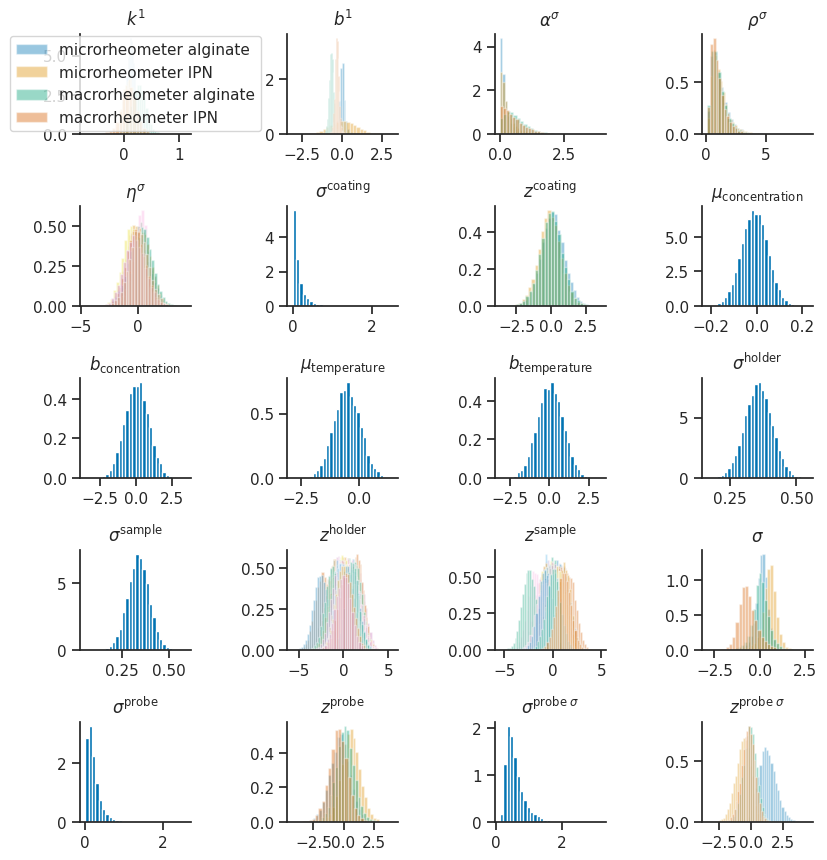

In [75]:
param_names = [
'$k^1$',
'$b^1$',
'$\\alpha^\\sigma$',
'$\\rho^\\sigma$',
'$\\eta^\\sigma$',
'$\sigma^{\mathrm{coating}}$',
'$z^{\mathrm{coating}}$',
'$\mu_{\mathrm{concentration}}$',
'$b_{\mathrm{concentration}}$',
'$\mu_{\mathrm{temperature}}$',
'$b_{\mathrm{temperature}}$',
'$\sigma^{\mathrm{holder}}$',
'$\sigma^{\mathrm{sample}}$',
'$z^{\mathrm{holder}}$',
'$z^{\mathrm{sample}}$',
'$\sigma$',
'$\sigma^{\mathrm{probe}}$',
'$z^{\mathrm{probe}}$',
'$\sigma^{\mathrm{probe}\;\sigma}$',
'$z^{\mathrm{probe}\;\sigma}$']


n = len(states._asdict().keys())
n_cols = 4
n_rows = int(np.ceil(n/n_cols))
fig,ax = plt.subplots(n_rows,n_cols,figsize=(8.27,11.69/4*3))

def pl(ax,name,p,x_trans=None):
    d = np.copy(states._asdict()[name])
    st = 'i j -> (i j)'
    r = False
    if len(d.shape)>2:
        st = 'i j k -> (i j) k'
        r = True
    xx = einops.rearrange(d,st)
    if x_trans is not None:
        xx = x_trans(xx)
    if len(d.shape)>2:
        if d.shape[-1]>4:
            for j in range(xx.shape[-1]):
                ax.hist(xx[:,j],density=True,bins=30,alpha=0.4)
        else:
            for j,k in zip(range(xx.shape[-1]),['microrheometer alginate','microrheometer IPN','macrorheometer alginate','macrorheometer IPN']):
                ax.hist(xx[:,j],density=True,bins=30,alpha=0.4,label=k)
    else:
        ax.hist(xx,density=True,bins=30)
    ax.set_title(r'{}'.format(p))
    #ax.set_title(r'{}'.format(p))
    return r

x_trans = lambda x: x*c_std+c_mean
done = False
for i,name,nn in zip(ax.ravel(),states._asdict(),param_names):
    if name in ['switchpoint']:
        ret = pl(i,name,nn,x_trans)
    else:
        ret = pl(i,name,nn,None)
    if ret and not done:
        done = True
        #i.legend()

d = np.copy(states._asdict()[name])
st = 'i j k -> (i j) k'
xx = einops.rearrange(d,st)

ax.ravel()[0].legend(loc='center')
fig.tight_layout()
fig.savefig(f'results/all_posteriors_{mec_type}.png',bbox_inches = 'tight',dpi=300)


In [76]:
az.bfmi(trace)

array([0.70653135, 0.6868783 , 0.67269677, 0.65933967], dtype=float32)

In [77]:
az.ess(trace)

<xarray.Dataset>
Dimensions:                  (names: 4, intercept_dim_0: 4,
                              sigma_eta_dim_0: 16, coating: 3,
                              holder_z_dim_0: 245, sample_z_dim_0: 84, radius: 4)
Coordinates:
  * names                    (names) <U14 'micro alginate' ... 'macro IPN'
  * intercept_dim_0          (intercept_dim_0) int64 0 1 2 3
  * sigma_eta_dim_0          (sigma_eta_dim_0) int64 0 1 2 3 4 ... 12 13 14 15
  * coating                  (coating) object 'COOH' 'NH2' 'plain'
  * holder_z_dim_0           (holder_z_dim_0) int64 0 1 2 3 ... 241 242 243 244
  * sample_z_dim_0           (sample_z_dim_0) int64 0 1 2 3 4 ... 79 80 81 82 83
  * radius                   (radius) object 10.0 30.0 50.0 100.0
Data variables: (12/25)
    slope1                   (names) float64 1.12e+04 1.166e+04 ... 1.565e+04
    intercept                (intercept_dim_0) float64 1.14e+04 ... 1.535e+04
    sigma_alpha              (names) float64 3.876e+03 3.384e+03 ... 4.545e+03
    sigma_rho                (names) float64 4.683e+03 5.144e+03 ... 5.444e+03
    sigma_eta                (sigma_eta_dim_0) float64 1.215e+04 ... 1.259e+04
    coating_std              float64 3.496e+03
    ...                       ...
    radius_sigma_z           (radius) float64 1.178e+04 1e+04 1.116e+04 1.05e+04
    radius_effect            (radius) float64 1.041e+04 7.871e+03 ... 9.834e+03
    radius_sigma_effect      (radius) float64 1.049e+04 1.04e+04 ... 1.03e+04
    coating_effect           (coating) float64 1.175e+04 1.132e+04 1.183e+04
    holder_effect            (holder_z_dim_0) float64 1.502e+04 ... 1.516e+04
    sample_effect            (sample_z_dim_0) float64 1.03e+04 ... 1.095e+04

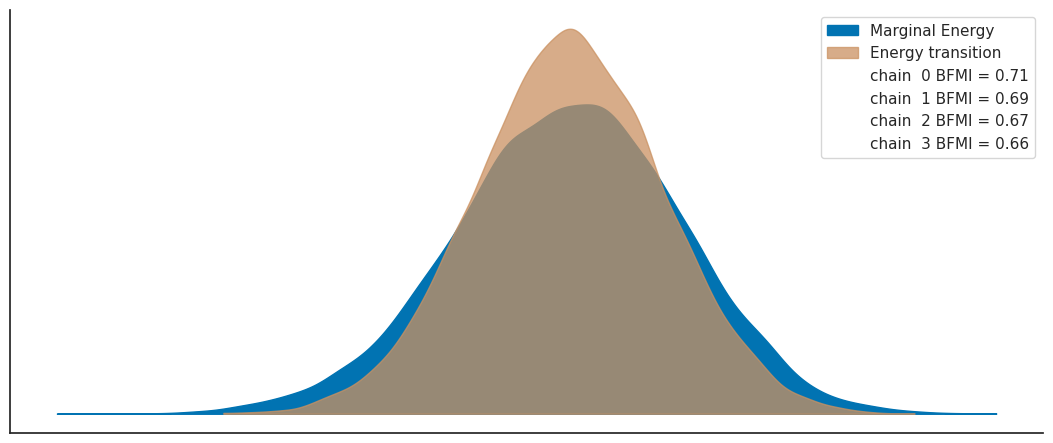

In [78]:
ax = az.plot_energy(trace)

/home/ossi/anaconda3/envs/2501/lib/python3.10/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


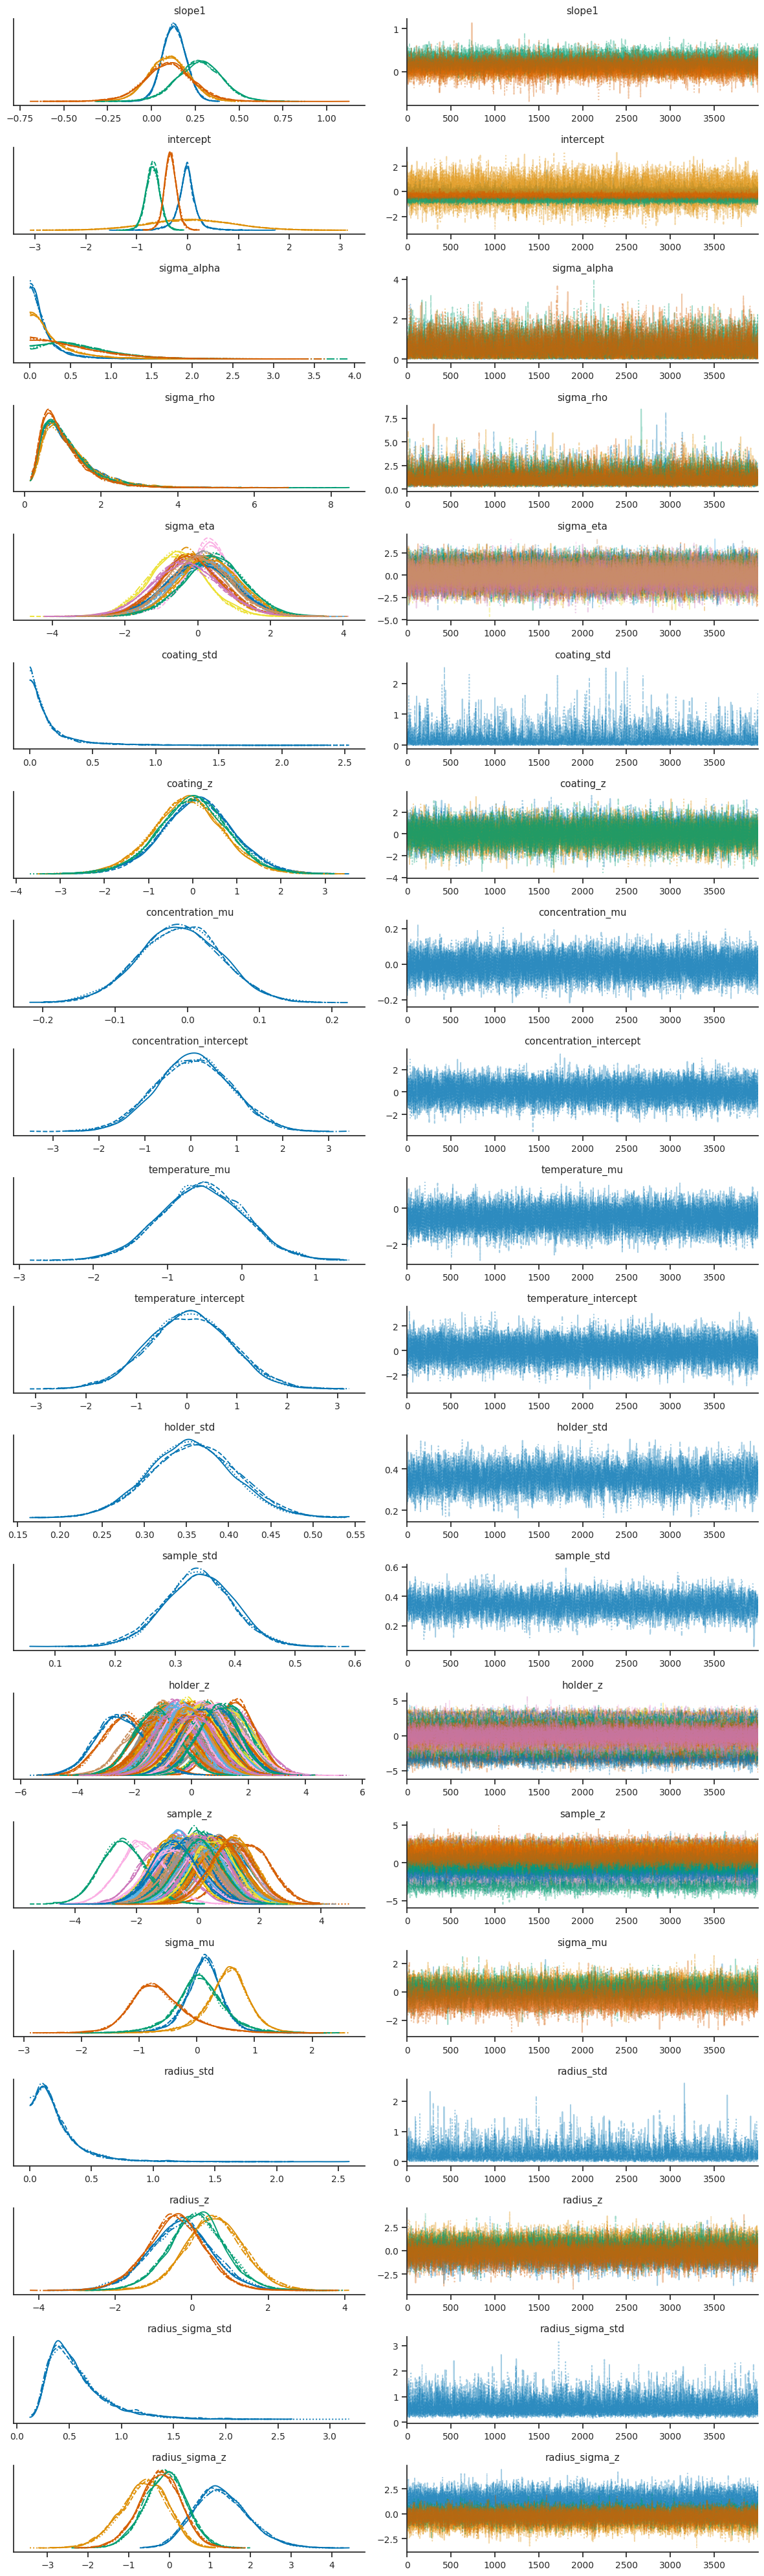

In [79]:
ax = az.plot_trace(trace)
ax[0,0].figure.tight_layout()

In [ ]:
diffs = {}
for k1,k2 in zip(np.unique(type_indices),np.unique(type_orig)):
    m1 = macro_type_indices==k1
    m2 = type_indices==k1
    diffs[k2] = {}
    for i,j in zip(np.unique(crosslinker_macro_raw),np.unique(crosslinker_macro)):
        macro_mask = np.logical_and(crosslinker_macro==j,m1)
        micro_mask = np.logical_and(crosslinker==j,m2)
        print(k2,i,macro_mask.sum(),micro_mask.sum())
        if micro_mask.sum()==0:
            continue
        mac = np.array(samps.likelihood_macro[...,macro_mask].mean(axis=-1).flatten())
        mic = np.array(samps.likelihood[...,micro_mask].mean(axis=-1).flatten())
        diff = mac-mic
        diffs[k2][i] = diff
        #_ = plt.hist(diff,bins=100,label=i,alpha=0.5)
    #plt.legend()

alginate 5.0 3 158


alginate 7.5 8 160
alginate 10.0 3 129
alginate 20.0 7 98
alginate 30.0 5 78
ipn 5.0 3 163
ipn 7.5 0 0
ipn 10.0 3 116
ipn 20.0 5 111
ipn 30.0 0 0


In [ ]:
comp = []
for k,k2 in diffs.items():
    tmp = pd.DataFrame(k2)
    tmp['material'] = k
    print(tmp.shape)
    comp.append(tmp.melt(id_vars=tmp.columns[-1],value_vars=tmp.columns[:-1],value_name='G',var_name='crosslinker'))
comp = pd.concat(comp)

(16000, 6)
(16000, 4)


In [ ]:
comp_df = pd.DataFrame(comp)
comp_df.columns

Index(['material', 'crosslinker', 'G'], dtype='object')

In [ ]:
for i,j in comp_df.groupby(['material','crosslinker']):
    probs = np.logical_and((j['G'].values<0.1),(j['G'].values>-0.1)).sum()/j.shape[0]*100
    print(i,probs)

('alginate', 5.0) 0.0
('alginate', 7.5) 0.78125
('alginate', 10.0) 0.17500000000000002
('alginate', 20.0) 51.112500000000004
('alginate', 30.0) 0.0
('ipn', 5.0) 0.0125
('ipn', 10.0) 0.0
('ipn', 20.0) 0.0


In [ ]:
df1 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_raw,'G':G,'type':'data',
                'material':data['type'].astype(pd.StringDtype()).reset_index()['type']}),
                pd.DataFrame({'crosslinker':crosslinker_raw,'G':jnp.mean(samps.likelihood,axis=(0,1)),
                              'type':'model',
                              'material':data['type'].astype(pd.StringDtype()).reset_index()['type']})]) 

df2 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_macro_raw,'G':G_macro,'type':'data',
                'material':macro['type'].astype(pd.StringDtype()).reset_index()['type']}),
                pd.DataFrame({'crosslinker':crosslinker_macro_raw,'G':jnp.mean(samps.likelihood_macro,axis=(0,1)),
                              'type':'model',
                              'material':macro['type'].astype(pd.StringDtype()).reset_index()['type']})])



In [ ]:
sub_sample = 100
df1 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_raw,'G':G,'type':'data',
                'material':data['type'].astype(pd.StringDtype()).reset_index()['type']}),
            pd.DataFrame({'G': einops.rearrange(np.array(samps.likelihood[::sub_sample]),'a b c -> (a b c)'),
                'crosslinker':np.tile(crosslinker_raw,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                'type':'model','material':np.tile(data['type'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2]))})])

df2 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_macro_raw,'G':G_macro,'type':'data',
                'material':macro['type'].astype(pd.StringDtype()).reset_index()['type']}),
            pd.DataFrame({'G': einops.rearrange(np.array(samps.likelihood_macro[::sub_sample]),'a b c -> (a b c)'),
                'crosslinker':np.tile(crosslinker_macro_raw,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                'type':'model','material':np.tile(macro['type'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2]))})])

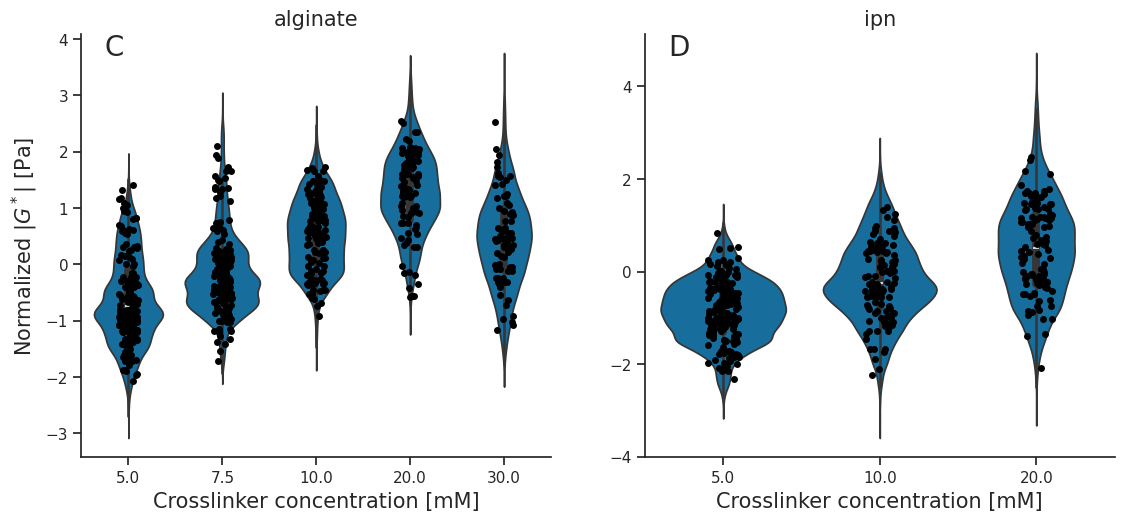

In [ ]:
fig,ax = plt.subplots(1,2)
sns.violinplot(data=df1[(df1['material']=='alginate') & (df1['type']=='model')],x='crosslinker',y='G',
               ax=ax[0],color=sns.color_palette('colorblind')[0])
sns.stripplot(data=df1[(df1['material']=='alginate') & (df1['type']=='data')],
              x='crosslinker',y='G',ax=ax[0],color='black')




sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],x='crosslinker',y='G',
               ax=ax[1],color=sns.color_palette('colorblind')[0])
sns.stripplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data')],
              x='crosslinker',y='G',ax=ax[1],color='black')

ax[1].set_title('ipn',fontsize=15)

ax[0].set_title('alginate',fontsize=15)
ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units),fontsize=15)
ax[1].set_ylabel('')
ax[0].set_xlabel(xlabel,fontsize=15)
ax[1].set_xlabel(xlabel,fontsize=15)
ax[0].text(0.05, 0.95, 'C', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'D', transform=ax[1].transAxes,fontsize=20)

fig.savefig(f'results/data_{mec_type}.png',bbox_inches = 'tight',dpi=300)

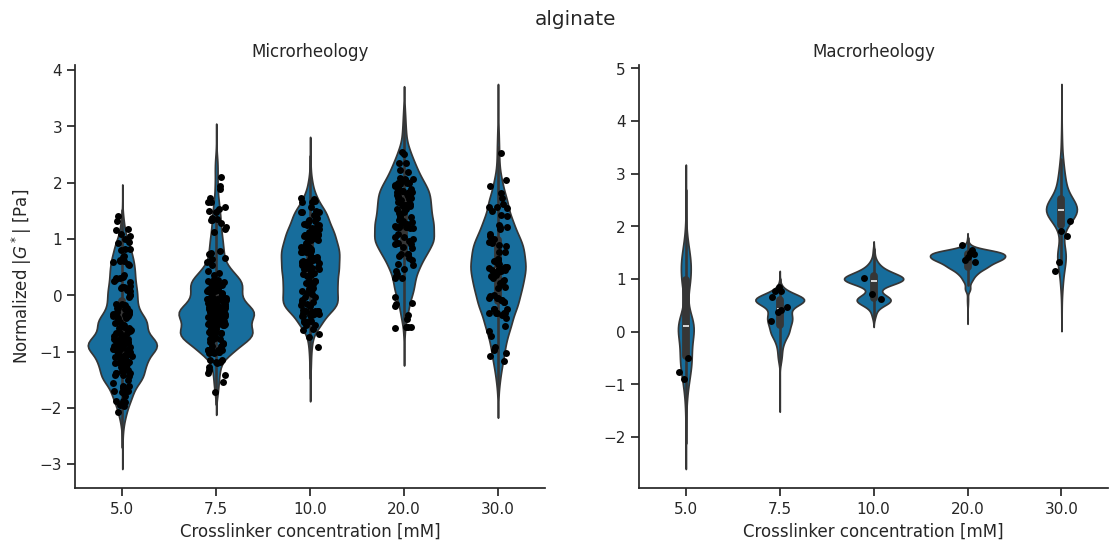

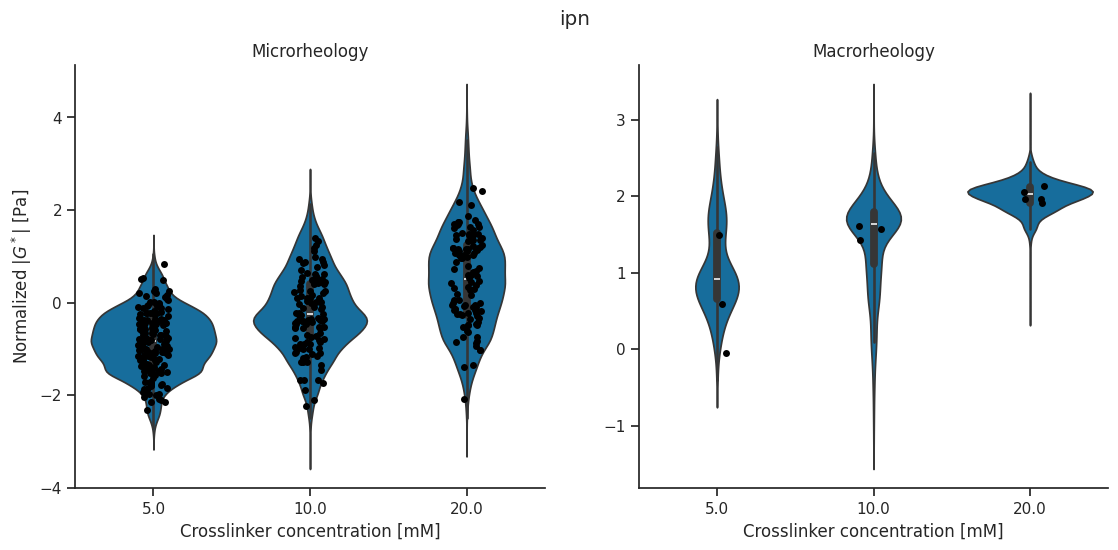

In [ ]:
fig,ax = plt.subplots(1,2)
sns.violinplot(data=df1[(df1['material']=='alginate') & (df1['type']=='model')],x='crosslinker',y='G',
               ax=ax[0],color=sns.color_palette('colorblind')[0])
sns.stripplot(data=df1[(df1['material']=='alginate') & (df1['type']=='data')],
              x='crosslinker',y='G',ax=ax[0],color='black')
sns.violinplot(data=df2[(df2['material']=='alginate') & (df2['type']=='model')],x='crosslinker',y='G',
               ax=ax[1],color=sns.color_palette('colorblind')[0])
sns.stripplot(data=df2[(df2['material']=='alginate') & (df2['type']=='data')],
              x='crosslinker',y='G',ax=ax[1],color='black')

ax[0].set_title('Microrheology')
ax[1].set_title('Macrorheology')
ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units))
ax[1].set_ylabel('')
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
fig.suptitle('alginate')

fig.savefig(f'results/posterior_alginate_{mec_type}.png',bbox_inches = 'tight',dpi=300)


fig,ax = plt.subplots(1,2)
sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],x='crosslinker',y='G',
               ax=ax[0],color=sns.color_palette('colorblind')[0])
sns.stripplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data')],
              x='crosslinker',y='G',ax=ax[0],color='black')
sns.violinplot(data=df2[(df2['material']=='ipn') & (df2['type']=='model')],x='crosslinker',y='G',
               ax=ax[1],color=sns.color_palette('colorblind')[0])
sns.stripplot(data=df2[(df2['material']=='ipn') & (df2['type']=='data')],
              x='crosslinker',y='G',ax=ax[1],color='black')

ax[0].set_title('Microrheology')
ax[1].set_title('Macrorheology')
ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units))
ax[1].set_ylabel('')
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
fig.suptitle('ipn')

fig.savefig(f'results/posterior_ipn_{mec_type}.png',bbox_inches = 'tight',dpi=300)

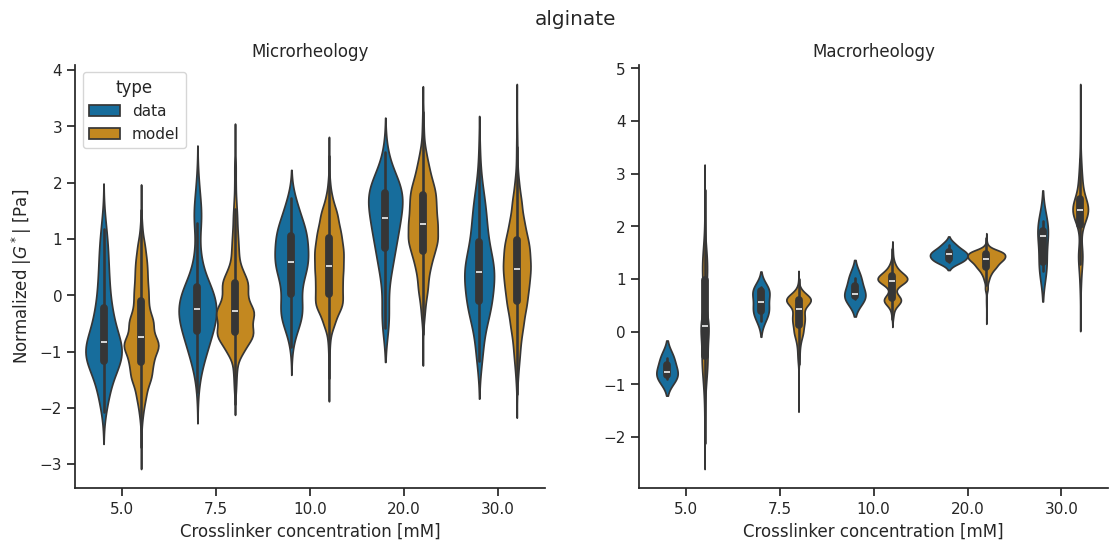

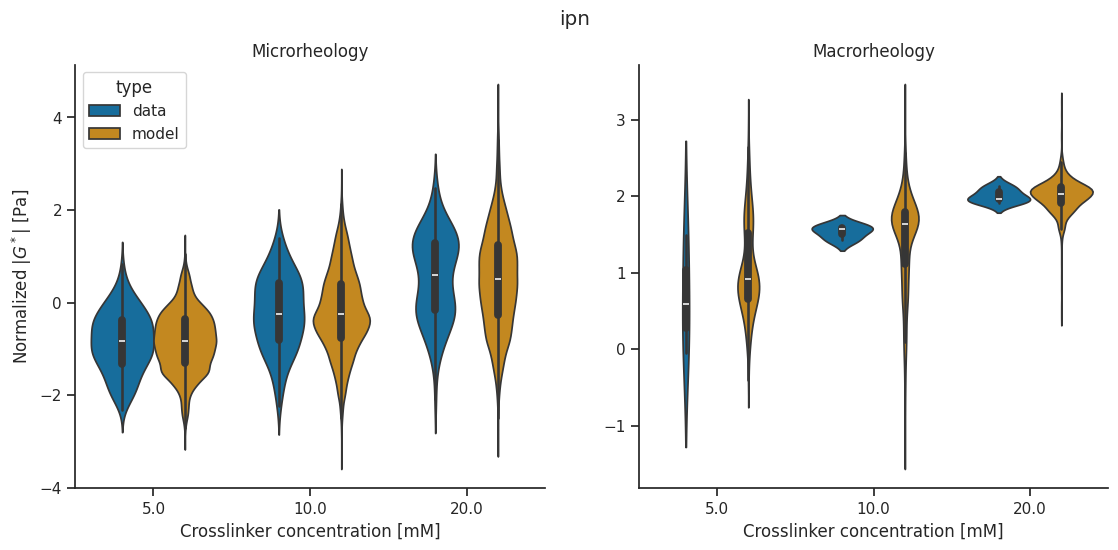

In [ ]:
fig,ax = plt.subplots(1,2)
sns.violinplot(data=df1[df1['material']=='alginate'],x='crosslinker',y='G',hue='type',ax=ax[0])
sns.violinplot(data=df2[df2['material']=='alginate'],x='crosslinker',y='G',hue='type',ax=ax[1])

ax[0].set_title('Microrheology')
ax[1].set_title('Macrorheology')
ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units))
ax[1].set_ylabel('')
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
ax[1].legend().remove()
fig.suptitle('alginate')

fig.savefig(f'results/posterior_alginate_{mec_type}.png',bbox_inches = 'tight',dpi=300)


fig,ax = plt.subplots(1,2)
sns.violinplot(data=df1[df1['material']=='ipn'],x='crosslinker',y='G',hue='type',ax=ax[0])
sns.violinplot(data=df2[df2['material']=='ipn'],x='crosslinker',y='G',hue='type',ax=ax[1])

ax[0].set_title('Microrheology')
ax[1].set_title('Macrorheology')
ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units))
ax[1].set_ylabel('')
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
ax[1].legend().remove()
fig.suptitle('ipn')

fig.savefig(f'results/posterior_ipn_{mec_type}.png',bbox_inches = 'tight',dpi=300)

In [ ]:
N_pred = 100
c_pred = jnp.linspace(crosslinker.min(),crosslinker.max(),N_pred)

In [ ]:
m1 = jnp.concatenate([np.zeros(N_alg),np.ones(N_ipn)]).astype(int)
m2 = jnp.concatenate([np.zeros(N_macro_alg),np.ones(N_macro_ipn)]).astype(int)+2
print(m1,m2)

m1_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),np.ones(N_ipn),np.ones(N_pred)]).astype(int)
print(m1_.shape)

m2_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),
                       np.ones(N_ipn),np.ones(N_pred),
                       np.zeros(N_macro_alg),np.zeros(N_pred),
                       np.ones(N_macro_ipn),np.ones(N_pred)]).astype(int)
print(m1_.shape,m2_.shape)

[0 0 0 0 0 1 1 1] [2 2 2 2 2 3 3 3]
(208,)
(208,) (416,)


In [ ]:
eta_key,sigma_eta_key = jr.split(key,2)
#N_samples = states.eta.shape[0]
num_c = states.sigma_alpha.shape[1]
sub_sample = 5
N_samples = states.sigma_rho[::sub_sample].shape[0]

combined_alg = jnp.concatenate([cross_unique_alg,c_pred])
combined_ipn = jnp.concatenate([cross_unique_ipn,c_pred])

combined_macro_alg = jnp.concatenate([cross_unique_macro_alg,c_pred])
combined_macro_ipn = jnp.concatenate([cross_unique_macro_ipn,c_pred])

N_combined_alg = combined_alg.shape[0]
N_combined_ipn = combined_ipn.shape[0]

N_split = N_combined_alg+N_combined_ipn

N_combined_macro_alg = combined_macro_alg.shape[0]
N_combined_macro_ipn = combined_macro_ipn.shape[0]

N_both = N_combined_alg+N_combined_ipn+N_combined_macro_alg+N_combined_macro_ipn


slope1 = states.slope1[::sub_sample,:][...,None]
intercept = states.intercept[::sub_sample,:][...,None]

curve = slope1*c_pred[None,None,None,...]+intercept

curve_datapoints = slope1*cross_unique[None,None,None,...]+intercept


eta_pred_sigma = jr.normal(sigma_eta_key,(*states.sigma_eta.shape[:2],N_pred))
eta_both_sigma = jnp.dstack([states.sigma_eta[...,:N_alg],eta_pred_sigma,
                             states.sigma_eta[...,N_alg:(N_alg+N_ipn)],eta_pred_sigma,
                             states.sigma_eta[...,N_micro:(N_micro+N_macro_alg)],eta_pred_sigma,
                             states.sigma_eta[...,(N_micro+N_macro_alg):((N_micro+N_macro_alg+N_macro_ipn))],eta_pred_sigma])


N_total_sigma = eta_both_sigma.shape[-1]

K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(
                # micro
                einops.rearrange(jax.vmap(partial(rbf,combined_alg[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,0],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,0],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c),

                einops.rearrange(jax.vmap(partial(rbf,combined_ipn[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,1],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,1],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c),
                # macro
                einops.rearrange(jax.vmap(partial(rbf,combined_macro_alg[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,2],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,2],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c),
                
                einops.rearrange(jax.vmap(partial(rbf,combined_macro_ipn[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,3],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,3],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_both)[None,None,...]*(1e-4)

L_K_sigma = jnp.linalg.cholesky(K_sigma)

sigma = jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,eta_both_sigma[::sub_sample])+states.sigma_mu[::sub_sample,:,m2_])

In [ ]:
curve_datapoints = einops.rearrange(curve_datapoints,'i j k n -> (i j) k n')

In [ ]:
print(((curve_datapoints[:,2]-curve_datapoints[:,0])<0).sum()/np.prod(curve_datapoints[:,2].shape)*100)
print(((curve_datapoints[:,3]-curve_datapoints[:,1])<0).sum()/np.prod(curve_datapoints[:,2].shape)*100)

21.199999
1.1312499


In [ ]:
print(np.logical_and((curve_datapoints[:,2]-curve_datapoints[:,0])>-0.1,(curve_datapoints[:,2]-curve_datapoints[:,0])<0.1).sum()/np.prod(curve_datapoints[:,2].shape)*100)
print(np.logical_and((curve_datapoints[:,3]-curve_datapoints[:,1])>-0.1,(curve_datapoints[:,3]-curve_datapoints[:,1])<0.1).sum()/np.prod(curve_datapoints[:,2].shape)*100)

7.581250000000001
0.70625


[40.46875   32.25      25.25       6.5312495  1.5      ]
[11.6875  10.96875  9.6875   4.46875  1.09375]
[0.59375    0.53125    0.59375    0.84375006 3.09375   ]
[0.40625 0.4375  0.375   0.6875  1.625  ]


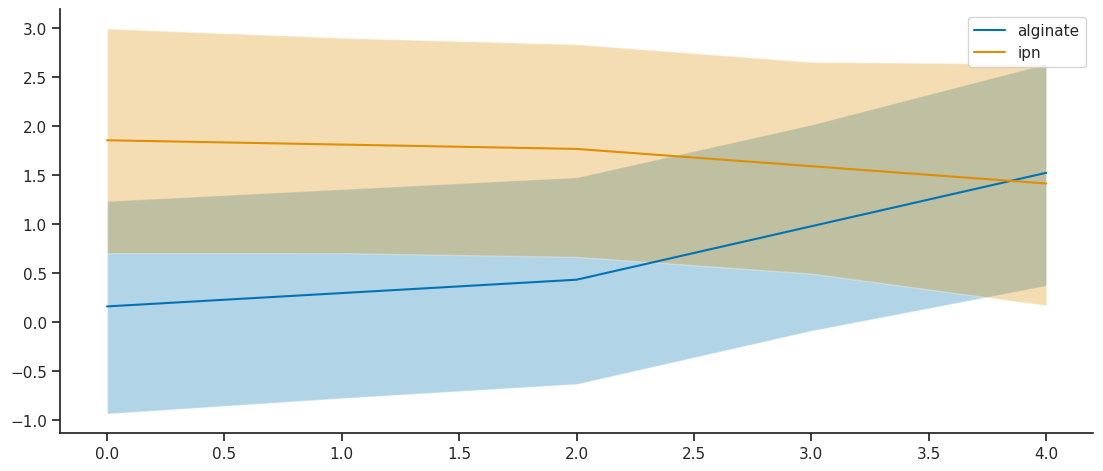

In [ ]:
fig = plt.figure()
def plot_diff(x,i,j,label):
    x1 = x[:,i]
    x2 = x[:,j]
    diff = x2-x1
    low = np.percentile(diff,5,axis=0)
    high = np.percentile(diff,95,axis=0)
    mean = np.mean(diff,axis=0)
    u = np.arange(mean.shape[0])
    _ = plt.plot(u,mean,label=label)
    _ = plt.fill_between(u,low,high,alpha=0.3)
    print((diff<0.0).sum(axis=0)/diff.shape[0]*100)
    mask1 = np.logical_and(diff>-0.1,diff<0.1)
    print((mask1.sum(axis=0))/diff.shape[0]*100)
plot_diff(curve_datapoints,0,2,'alginate')
plot_diff(curve_datapoints,1,3,'ipn')
plt.legend()

Save the heterogeneity so that the joint plot can be generated in switchpoint.ipynb

In [ ]:
np.save(os.path.join(path,'phi_prob_comp.npy'),curve)

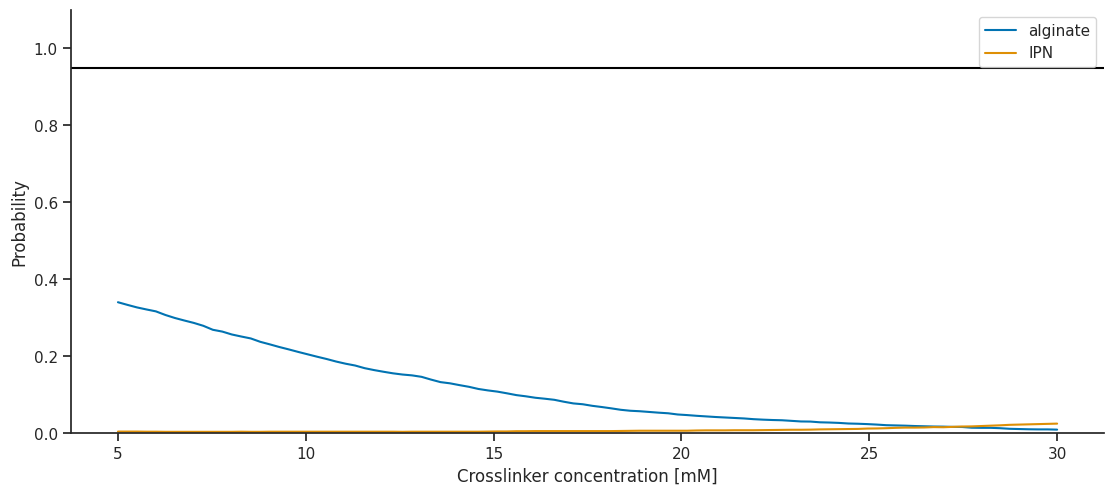

In [ ]:
def compa(x,ax,i,j,label):
    if i is not None:
        t = einops.rearrange(x[:,:,i],'i j t-> (i j) t')
    if j is not None:
        tt2 = einops.rearrange(x[:,:,j],'i j t-> (i j) t')
    else:
        tt2 = einops.rearrange(x,'i j k -> (i j) k')

    tt = tt2-t
    r = (tt<-0.1).sum(axis=0)/tt.shape[0]
    ax.plot(c_pred*c_std+c_mean,r,label=label)

fig,ax = plt.subplots(1,1)
compa(curve,ax,0,2,'alginate')
compa(curve,ax,1,3,'IPN')
ax.axhline(0.95,color='black')
ax.set_xlabel(xlabel)
ax.set_ylabel('Probability')
ax.set_ylim([0,1.1])
ax.legend()
fig.savefig(f'results/micromacro_phi.png',bbox_inches = 'tight',dpi=300)

88.85
100.0
100.0
99.9125


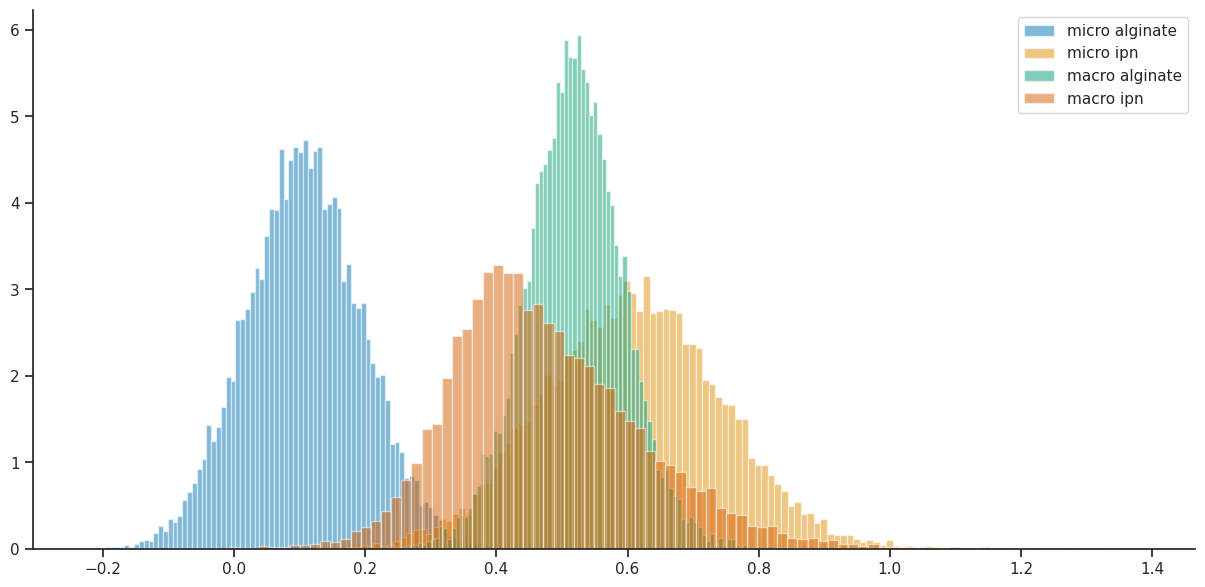

In [ ]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
ee = einops.rearrange(states.slope1, 'i j l -> (i j) l')
fig = plt.figure(figsize=(15,7))
for i,j in zip(range(ee.shape[-1]),names):
    print(np.sum(ee[:,i]>0.0)/ee[:,i].shape[0]*100)
    _ = plt.hist(ee[:,i],bins=100,alpha=0.5,label=j,density=True)
_ = plt.legend()

Text(0.5, 1.0, 'mean+sigma')

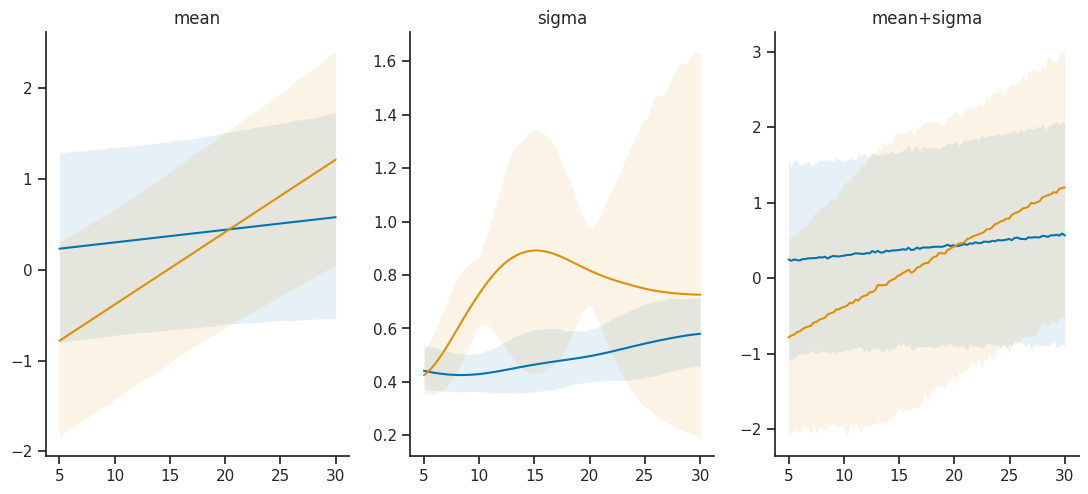

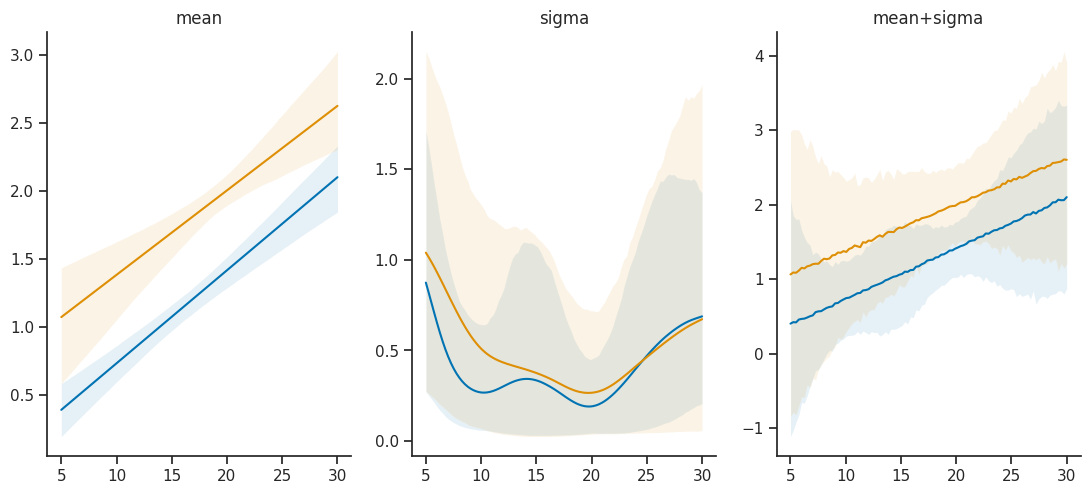

In [ ]:
def plottos(x,ax,i=None):
    if i is not None:
        tt = einops.rearrange(x[:,:,i],'i j t-> (i j) t')
    else:
        tt = einops.rearrange(x,'i j k -> (i j) k')
    low = np.percentile(tt,5,axis=0)
    up = np.percentile(tt,95,axis=0)
    mean = np.mean(tt,axis=0)
    ax.plot(c_pred*c_std+c_mean,mean)
    ax.fill_between(c_pred*c_std+c_mean,low,up,alpha=0.1)

def plot_posterior(x,y,ax,i):
    tt1 = einops.rearrange(x[:,:,i],'i j t-> (i j) t')
    tt2 = einops.rearrange(y,'i j k -> (i j) k')
    tt = tt1+np.random.normal(0,1,tt1.shape)*tt2
    low = np.percentile(tt,5,axis=0)
    up = np.percentile(tt,95,axis=0)
    mean = np.mean(tt,axis=0)
    ax.plot(c_pred*c_std+c_mean,mean)
    ax.fill_between(c_pred*c_std+c_mean,low,up,alpha=0.1)

fig,ax = plt.subplots(1,3)
plottos(curve,ax[0],0)
plottos(curve,ax[0],1)
plottos(sigma[:,:,N_alg:(N_alg+N_pred)],ax[1],None)
plottos(sigma[:,:,(N_ipn+N_alg+N_pred):(N_ipn+N_alg+2*N_pred)],ax[1],None)
plot_posterior(curve,sigma[:,:,N_alg:(N_alg+N_pred)],ax[2],0)
plot_posterior(curve,sigma[:,:,(N_ipn+N_alg+N_pred):(N_ipn+N_alg+2*N_pred)],ax[2],1)

ax[0].set_title('mean')
ax[1].set_title('sigma')
ax[2].set_title('mean+sigma')

fig,ax = plt.subplots(1,3)
plottos(curve,ax[0],2)
plottos(curve,ax[0],3)
plottos(sigma[:,:,(N_split+N_macro_alg):(N_split+N_macro_alg+N_pred)],ax[1],None)
plottos(sigma[:,:,(N_split+N_macro_ipn+N_macro_alg+N_pred):(N_split+N_macro_ipn+N_macro_alg+2*N_pred)],ax[1],None)
plot_posterior(curve,sigma[:,:,(N_split+N_macro_alg):(N_split+N_macro_alg+N_pred)],ax[2],2)
plot_posterior(curve,sigma[:,:,(N_split+N_macro_ipn+N_macro_alg+N_pred):(N_split+N_macro_ipn+N_macro_alg+2*N_pred)],ax[2],3)

ax[0].set_title('mean')
ax[1].set_title('sigma')
ax[2].set_title('mean+sigma')

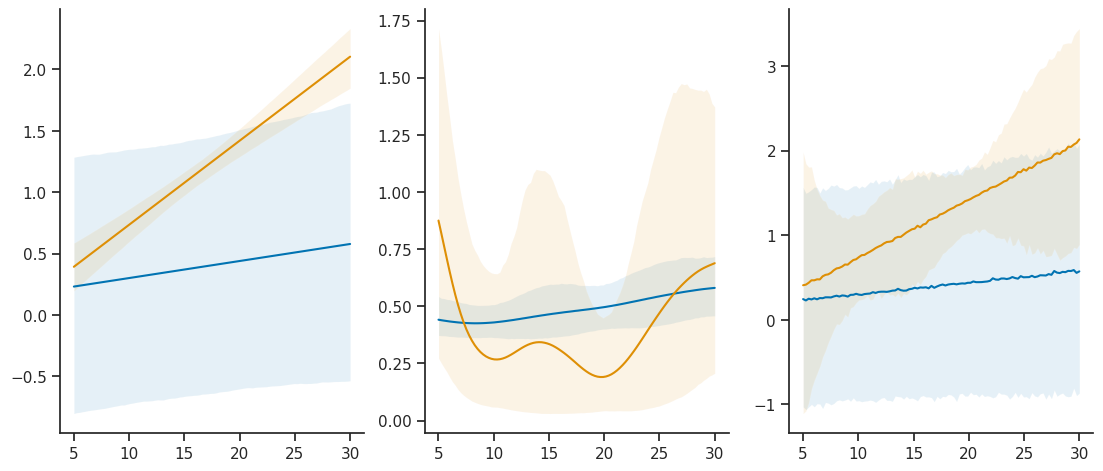

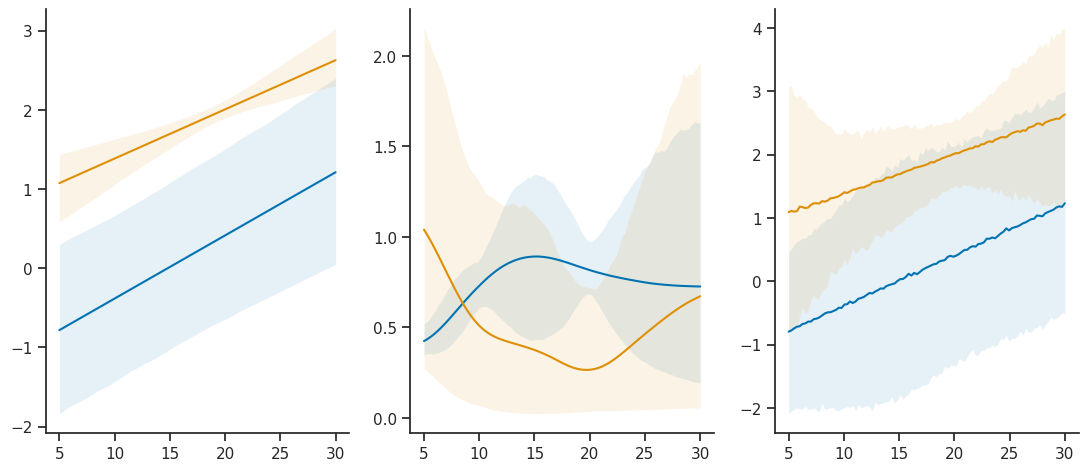

In [ ]:
fig,ax = plt.subplots(1,3)
plottos(curve,ax[0],0)
plottos(curve,ax[0],2)
plottos(sigma[:,:,N_alg:(N_alg+N_pred)],ax[1],None)
plottos(sigma[:,:,(N_split+N_macro_alg):(N_split+N_macro_alg+N_pred)],ax[1],None)
plot_posterior(curve,sigma[:,:,N_alg:(N_alg+N_pred)],ax[2],0)
plot_posterior(curve,sigma[:,:,(N_split+N_macro_alg):(N_split+N_macro_alg+N_pred)],ax[2],2)

fig,ax = plt.subplots(1,3)
plottos(curve,ax[0],1)
plottos(curve,ax[0],3)
plottos(sigma[:,:,(N_ipn+N_alg+N_pred):(N_ipn+N_alg+2*N_pred)],ax[1],None)
plottos(sigma[:,:,(N_split+N_macro_ipn+N_macro_alg+N_pred):(N_split+N_macro_ipn+N_macro_alg+2*N_pred)],ax[1],None)
plot_posterior(curve,sigma[:,:,(N_ipn+N_alg+N_pred):(N_ipn+N_alg+2*N_pred)],ax[2],1)
plot_posterior(curve,sigma[:,:,(N_split+N_macro_ipn+N_macro_alg+N_pred):(N_split+N_macro_ipn+N_macro_alg+2*N_pred)],ax[2],3)


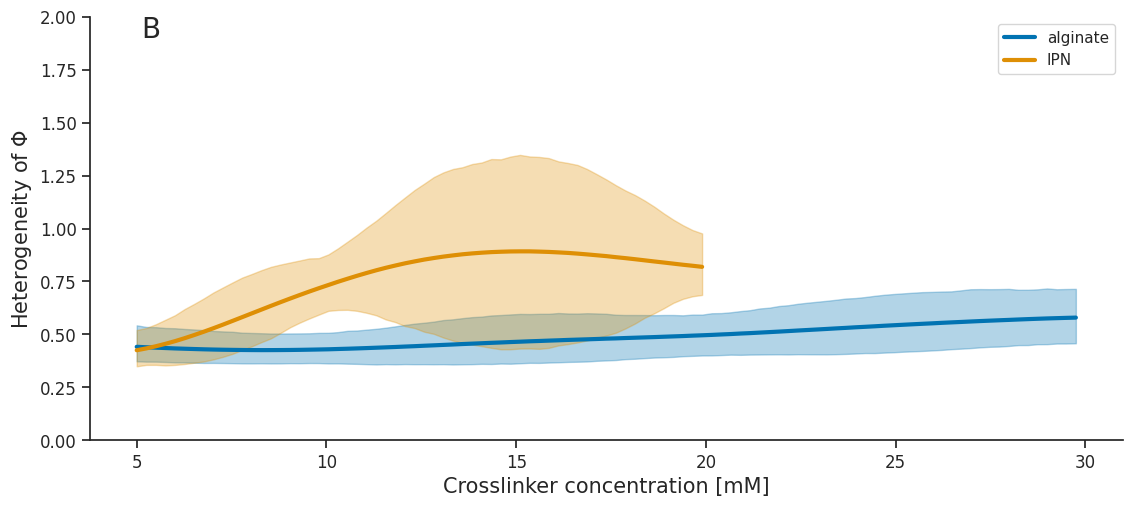

In [ ]:
fig,ax = plt.subplots(1,1)
for x1,x2,t,c,d,e,f in zip([N_alg,N_ipn+N_alg+N_pred],
                     [N_alg+N_pred,N_ipn+N_alg+2*N_pred],
                     [0,1],
                     sns.color_palette('colorblind')[:2],
                     ['alginate','IPN'],['-','--'],['/','\\']):

    mask = c_pred<crosslinker[type_indices==t].max()
    res = sigma[...,x1:x2]
    c_pred_masked = c_pred[mask]
    res = einops.rearrange(res,'n m t -> (n m) t')
    res = res[...,mask]
    r_p1 = jnp.percentile(res,5,axis=0)
    r_p2 = jnp.percentile(res,95,axis=0)
    r_mean = jnp.mean(res,axis=0)

    rr = r_mean#*g_std+g_mean
    r1 = r_p1#*g_std+g_mean
    r2 = r_p2#*g_std+g_mean
    #if mec_type!='G_':
    #    rr = jnp.exp(rr)
    #    r1 = jnp.exp(r1)
    #    r2 = jnp.exp(r2)
    ax.plot(c_pred_masked*c_std+c_mean,rr,color=c,label=d,linewidth=3)
    ax.fill_between(c_pred_masked*c_std+c_mean,r1,r2,color=c,alpha=0.3)
    #for j in range(0,res.shape[0],300):
    #    ax.plot(c_pred_masked*c_std+c_mean,res[j],color=c,linewidth=1,alpha=0.5)
    #ax.set_xlim(crosslinker_raw[type_indices==t].min()-0.5,crosslinker_raw[type_indices==t].max()+1)
    #ax.axvline(states.switchpoint[:,:,t].mean()*c_std+c_mean,color=c)
#if mec_type=='G':
#    ax.set_title(r'heterogeneity of |G$^*$|')
#else:
#    ax.set_title(r'heterogeneity of $\Phi$')
ax.set_xlabel(xlabel,fontsize=15)
ax.set_ylabel(r'Heterogeneity of $\Phi$',fontsize=15)
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12)
ax.text(0.05, 0.95, 'B', transform=ax.transAxes,fontsize=20)
ax.set_ylim([0,2])
#ax.set_ylabel('Heterogeneity')
ax.legend()
fig.savefig(f'results/heterogeneity_cont_{mec_type}.png',bbox_inches = 'tight',dpi=300)

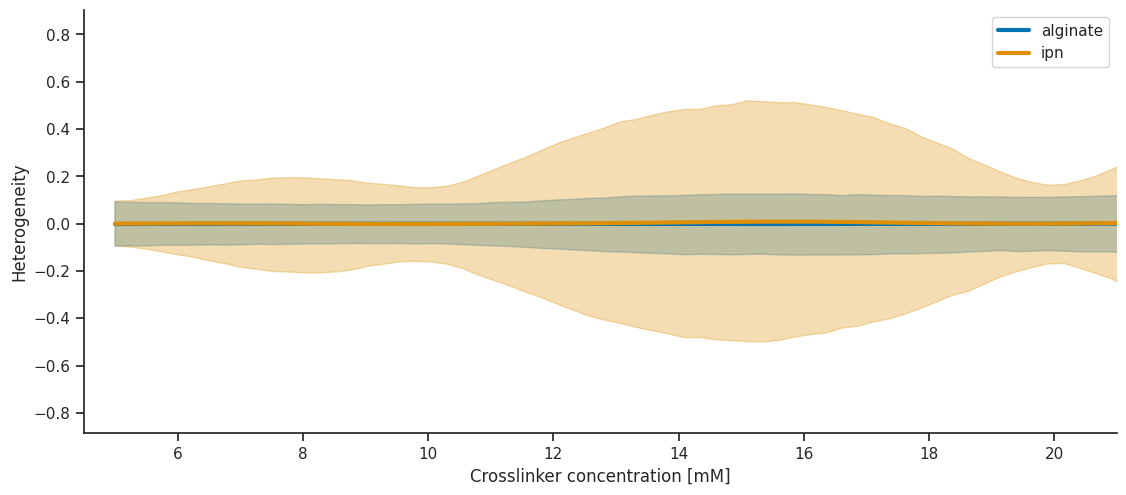

In [ ]:
fig,ax = plt.subplots(1,1)
for x1,x2,t,c,d,e,f in zip([N_alg,N_ipn+N_alg+N_pred],
                     [N_alg+N_pred,N_ipn+N_alg+2*N_pred],
                     [0,1],
                     sns.color_palette('colorblind')[:2],
                     ['alginate','ipn'],['-','--'],['/','\\']):

    res = np.gradient(sigma[...,x1:x2],axis=1)
    res = einops.rearrange(res,'n m t -> (n m) t')
    r_p1 = jnp.percentile(res,5,axis=0)
    r_p2 = jnp.percentile(res,95,axis=0)
    r_mean = jnp.mean(res,axis=0)

    rr = r_mean#*g_std+g_mean
    r1 = r_p1#*g_std+g_mean
    r2 = r_p2#*g_std+g_mean
    #if mec_type!='G_':
    #    rr = jnp.exp(rr)
    #    r1 = jnp.exp(r1)
    #    r2 = jnp.exp(r2)
    ax.plot(c_pred*c_std+c_mean,rr,color=c,label=d,linewidth=3)
    ax.fill_between(c_pred*c_std+c_mean,r1,r2,color=c,alpha=0.3)
    ax.set_xlim(crosslinker_raw[type_indices==t].min()-0.5,crosslinker_raw[type_indices==t].max()+1)
#if mec_type=='G':
#    ax.set_title(r'heterogeneity of |G$^*$|')
#else:
#    ax.set_title(r'heterogeneity of $\Phi$')
ax.set_xlabel(xlabel)
#ax.set_ylabel(r'${}$ [${}$]'.format(naming,units))
ax.set_ylabel('Heterogeneity')
ax.legend()

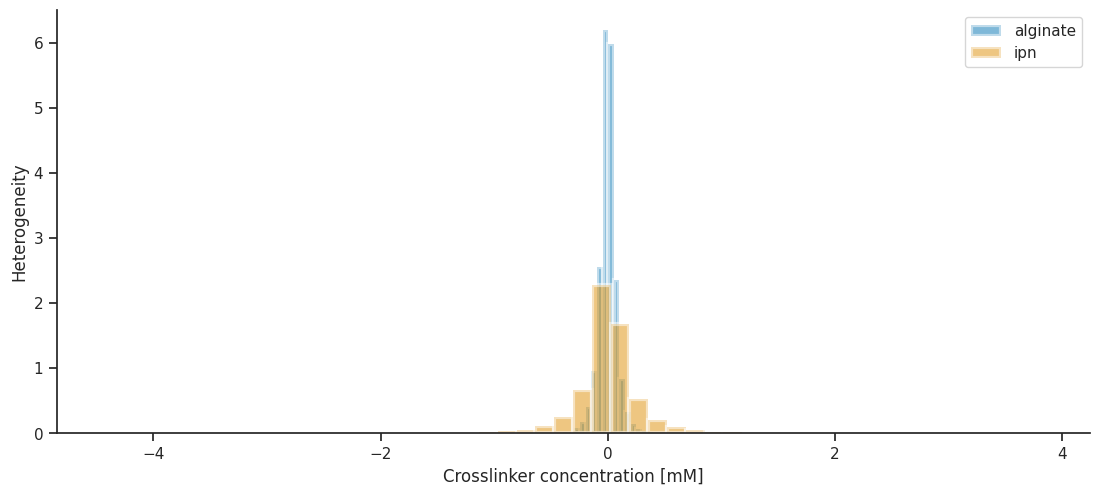

In [ ]:
fig,ax = plt.subplots(1,1)
for x1,x2,t,c,d,e,f in zip([N_alg,N_ipn+N_alg+N_pred],
                     [N_alg+N_pred,N_ipn+N_alg+2*N_pred],
                     [0,1],
                     sns.color_palette('colorblind')[:2],
                     ['alginate','ipn'],['-','--'],['/','\\']):

    res = np.gradient(sigma[...,x1:x2],axis=1)
    res = einops.rearrange(res,'n m t -> (n m t)')
    #r_p1 = jnp.percentile(res,5,axis=0)
    #r_p2 = jnp.percentile(res,95,axis=0)
    #r_mean = jnp.mean(res,axis=0)

    #rr = r_mean#*g_std+g_mean
    #r1 = r_p1#*g_std+g_mean
    #r2 = r_p2#*g_std+g_mean
    #if mec_type!='G_':
    #    rr = jnp.exp(rr)
    #    r1 = jnp.exp(r1)
    #    r2 = jnp.exp(r2)
    ax.hist(res,color=c,label=d,linewidth=3,bins=50,alpha=0.5,density=True)
    #ax.fill_between(c_pred*c_std+c_mean,r1,r2,color=c,alpha=0.3)
    #ax.set_xlim(crosslinker_raw[type_indices==t].min()-0.5,crosslinker_raw[type_indices==t].max()+1)
#if mec_type=='G':
#    ax.set_title(r'heterogeneity of |G$^*$|')
#else:
#    ax.set_title(r'heterogeneity of $\Phi$')
ax.set_xlabel(xlabel)
#ax.set_ylabel(r'${}$ [${}$]'.format(naming,units))
ax.set_ylabel('Heterogeneity')
ax.legend()


In [ ]:
s1 = sigma[...,N_alg:(N_alg+N_pred)]
s2 = sigma[...,(N_ipn+N_alg+N_pred):(N_ipn+N_alg+2*N_pred)]

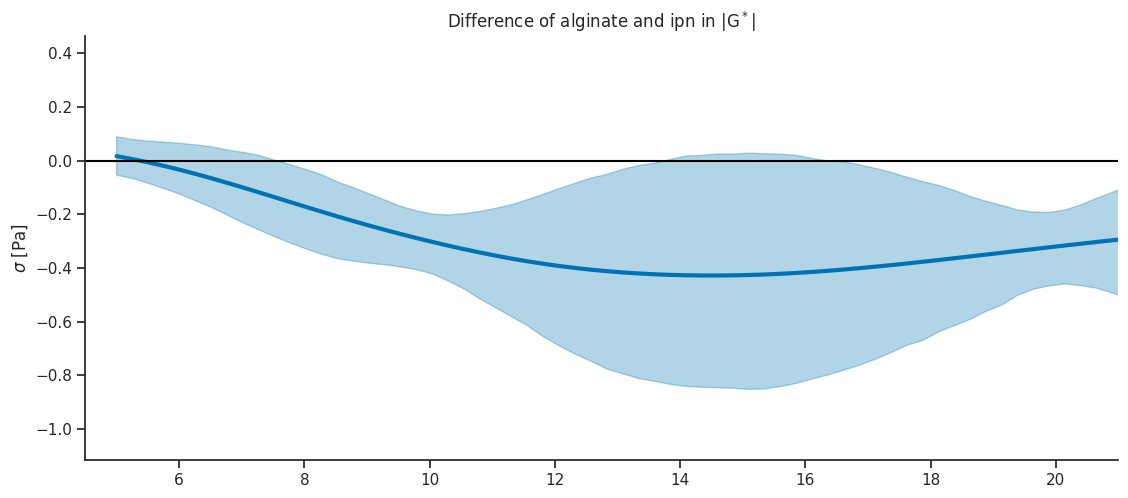

In [ ]:
fig,ax = plt.subplots(1,1)

#ss1 = jnp.exp(s1*g_std+g_mean)
#ss2 = jnp.exp(s2*g_std+g_mean)
ss1 = s1 
ss2 = s2
diff = (ss1-ss2)
res = einops.rearrange(diff,'n m t -> (n m) t')

r_p1 = jnp.percentile(res,5,axis=0)
r_p2 = jnp.percentile(res,95,axis=0)

r_mean = jnp.mean(res,axis=0)

ax.plot(c_pred*c_std+c_mean,r_mean,color=sns.color_palette('colorblind')[0],label=d,linewidth=3)
ax.fill_between(c_pred*c_std+c_mean,r_p1,r_p2,color=sns.color_palette('colorblind')[0],alpha=0.3)
#ax.axhspan(-0.1,0.1,alpha=0.2,color='.5')
ax.axhline(0,color='black')
if mec_type=='G':
    ax.set_title(r'Difference of alginate and ipn in |G$^*$|')
else:
    ax.set_title(r'Difference of alginate and ipn in $\Phi$')
ax.set_ylabel(r'${}$ [{}]'.format('\sigma',units))
ax.set_xlim(crosslinker_raw[type_indices==t].min()-0.5,crosslinker_raw[type_indices==t].max()+1)
fig.savefig(f'results/heterogeneity_diff_raw_{mec_type}.png',bbox_inches = 'tight',dpi=300)

In [ ]:
np.save(os.path.join(path,'phi_comp_algi.npy'),(res<-0.1).sum(axis=0)/res.shape[0])

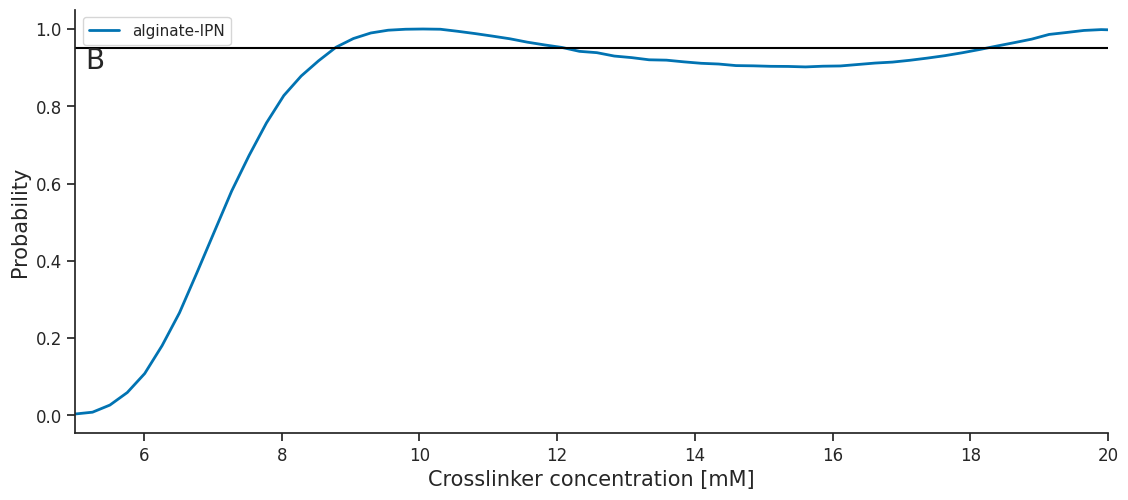

In [ ]:
fig,ax = plt.subplots(1,1)
xi = c_pred*c_std+c_mean
ax.plot(xi,(res<-0.1).sum(axis=0)/res.shape[0],linewidth=2,label='alginate-IPN',color=sns.color_palette('colorblind')[0])
ax.set_ylabel('Probability',fontsize=15)
ax.set_xlabel(xlabel,fontsize=15)
#if mec_type =='G':
#    ax.set_title(f'Probability of alginate having smaller heterogeneity than ipn in |G$^*$|')
#else:
#    ax.set_title(f'Probability of alginate having smaller heterogeneity than ipn in $\Phi$')

def vals(a,b,i):
    ax.axhspan(a,b,color=sns.color_palette('colorblind')[i],alpha=0.3)
#vals(0.95,1,1)
#vals(0.975,0.99,2)
plt.axhline(0.95,color='black')
#vals(0.99,0.999,3)
#vals(0.999,1.,4)
#ax.axhline(0.95,color=sns.color_palette('colorblind')[1],label='95% threshold',linewidth=3)
#ax.axhline(0.975,color=sns.color_palette('colorblind')[2],label='97.5% threshold',linewidth=3)
#ax.axhline(0.99,color=sns.color_palette('colorblind')[3],label='99% threshold',linewidth=3)
#ax.axhline(0.999,color=sns.color_palette('colorblind')[4],label='99.9% threshold',linewidth=3)

ax.legend()
ax.set_xlim([5,20])
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12)
ax.text(0.01, 0.86, 'B', transform=ax.transAxes,fontsize=20)
fig.savefig(f'results/heterogeneity_diff_prob_{mec_type}.png',bbox_inches = 'tight',dpi=300)
np.save('phi_comp_algi.npy',(res<-0.1).sum(axis=0)/res.shape[0])

In [ ]:
rads = []
for i,j in zip(np.unique(crosslinker_raw),np.unique(crosslinker)):
    mask = crosslinker_raw==i
    if ((cross_unique_alg==j)>0).sum()==1:
        print('alg',i,np.unique(radius_indices[mask]),end=' ')
        rad_effects = einops.rearrange((states.radius_std[...,None]*states.radius_z[:,:,np.unique(radius_indices[mask])]),'i j k -> (i j k)')
        i_name = 'alginate'
        if ((cross_unique_ipn==j)>0).sum()==1:
            i_name = 'alginate + ipn'
            print('ipn',np.unique(radius_indices[crosslinker_raw==i]))
        else:
            print('')
        rads.append(pd.DataFrame({'crosslinker':np.ones(rad_effects.shape[0])*i,'effect':rad_effects,'material':i_name}))
rad_df = pd.concat(rads)

alg 5.0 [0 1] ipn [0 1]
alg 7.5 [0 1] 
alg 10.0 [1 2 3] ipn [1 2 3]
alg 20.0 [1 2 3] ipn [1 2 3]
alg 30.0 [2 3] 


/tmp/ipykernel_1028/2400297333.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=rad_df,x='crosslinker',y='effect',hue='material',ax=ax,dodge=False,palette=sns.color_palette('colorblind'),cut=True)


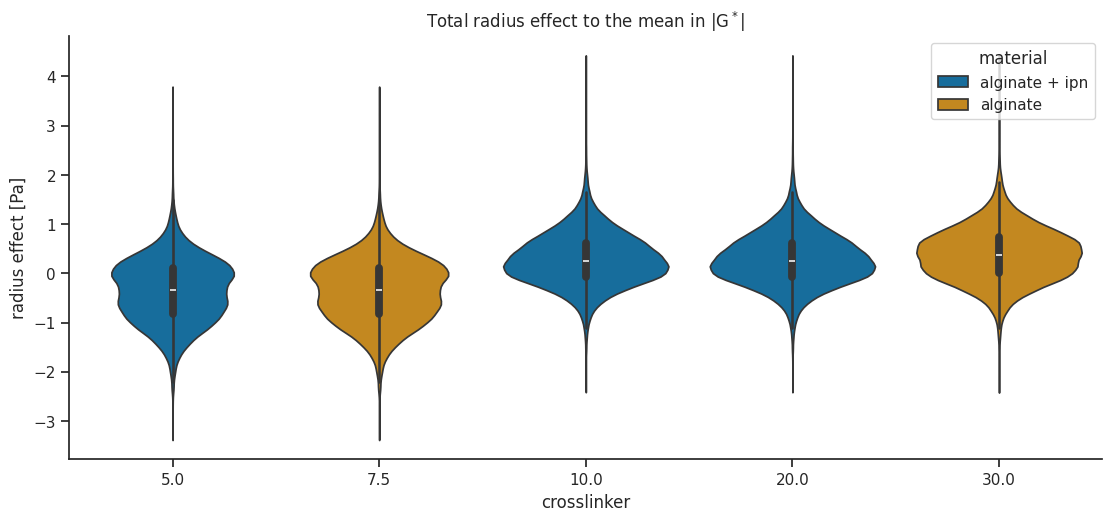

In [ ]:
fig,ax = plt.subplots(1,1)
sns.violinplot(data=rad_df,x='crosslinker',y='effect',hue='material',ax=ax,dodge=False,palette=sns.color_palette('colorblind'),cut=True)
ax.set_ylabel('radius effect [{}]'.format(units))
if mec_type =='G':
    ax.set_title(f'Total radius effect to the mean in |G$^*$|')
else:
    ax.set_title(f'Total radius effect to the mean in $\Phi$')
fig.savefig(f'results/mean_radius_{mec_type}.png',bbox_inches = 'tight',dpi=300)

In [ ]:
sub_sample = 1
N_samples = states.sigma_rho[::sub_sample].shape[0] 
num_c = states.sigma_alpha.shape[1]
K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(einops.rearrange(jax.vmap(partial(rbf,cross_unique_alg[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,0],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,0],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c),
        einops.rearrange(jax.vmap(partial(rbf,cross_unique_ipn[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,1],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,1],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_micro)[None,None,...]*(1e-5)


L_K_sigma = jnp.linalg.cholesky(K_sigma)
sigma = einops.rearrange(jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,states.sigma_eta[::sub_sample,:,:N_micro])+states.sigma_mu[::sub_sample,:,m1]),
                         'a b c -> (a b) c')

df2 = pd.DataFrame({'crosslinker':np.tile(np.round(np.concatenate([cross_unique_alg,cross_unique_ipn])*c_std+c_mean,1),
                                          sigma.shape[0]),'heterogeneity':sigma.flatten(),
                    'type':np.tile([*['alg']*N_alg,*['ipn']*N_ipn],sigma.shape[0])})

K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(einops.rearrange(jax.vmap(partial(rbf,cross_unique_macro_alg[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,2],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,2],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c),
        einops.rearrange(jax.vmap(partial(rbf,cross_unique_macro_ipn[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,3],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,3],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_macro)[None,None,...]*(1e-5)


L_K_sigma = jnp.linalg.cholesky(K_sigma)
sigma = einops.rearrange(jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,states.sigma_eta[::sub_sample,:,N_micro:])+states.sigma_mu[::sub_sample,:,m2]),
                         'a b c -> (a b) c')

df3 = pd.DataFrame({'crosslinker':np.tile(np.round(np.concatenate([cross_unique_macro_alg,cross_unique_macro_ipn])*c_std+c_mean,1),
                                          sigma.shape[0]),'heterogeneity':sigma.flatten(),
                    'type':np.tile([*['alg']*N_macro_alg,*['ipn']*N_macro_ipn],sigma.shape[0])})

df2.loc[df2['type']=='alg','type'] = 'alginate'

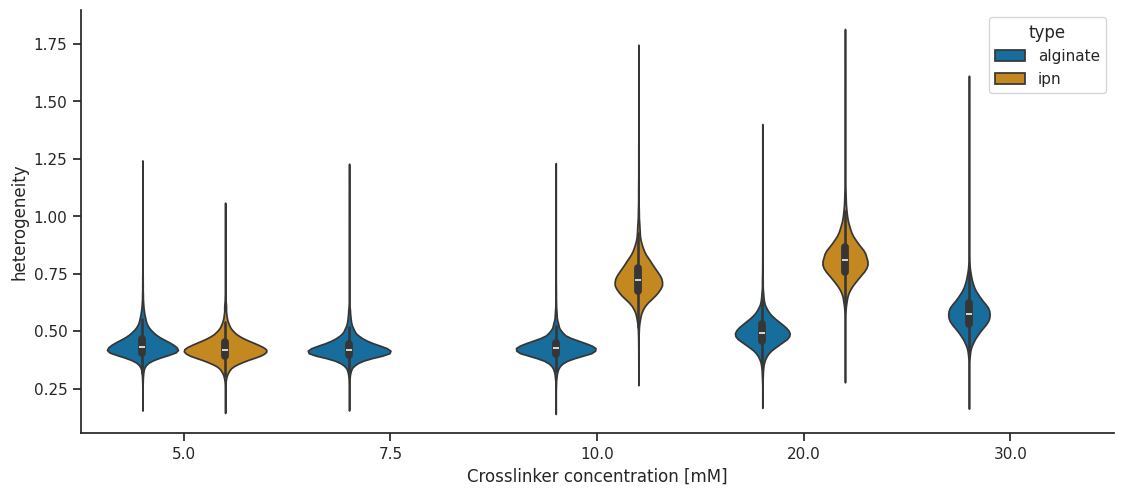

In [ ]:
fig,ax = plt.subplots(1,1)
sns.violinplot(data=df2,x='crosslinker',y='heterogeneity',hue='type',ax=ax)
#ax.set_title(r'Heterogeneity of ${}$'.format(naming))
#ax.set_ylabel(r'Normalized ${}$ [${}$]'.format(naming,units))

ax.set_xlabel(xlabel)
fig.savefig(f'results/heterogeneity_{mec_type}.png',bbox_inches = 'tight',dpi=300)

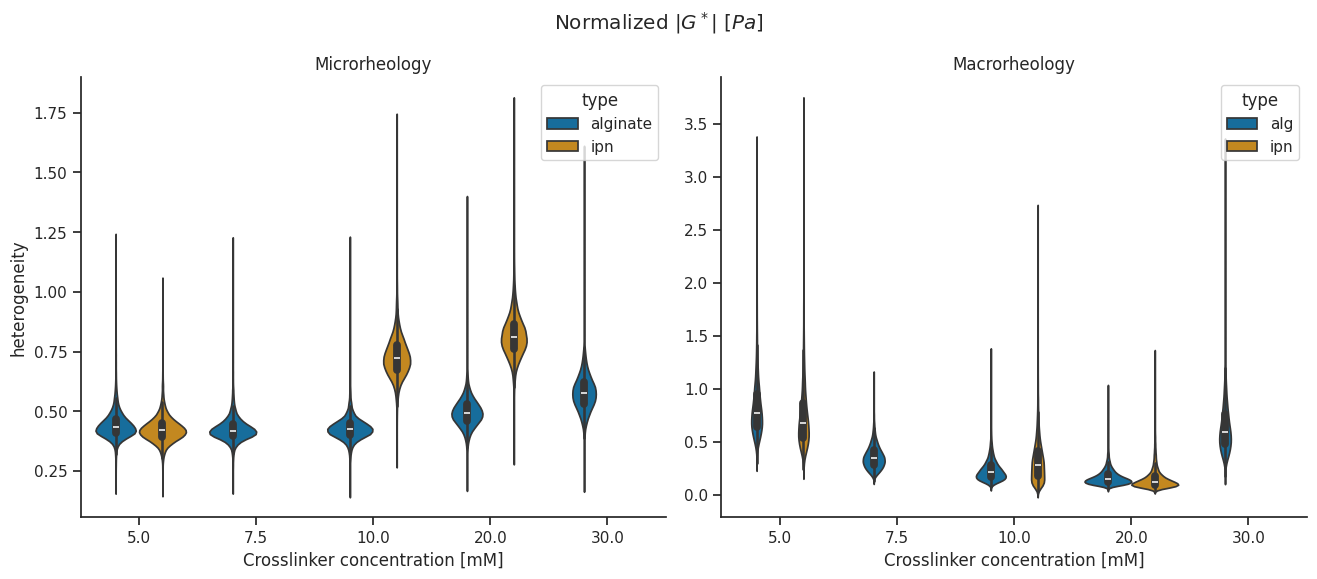

In [ ]:
fig,ax = plt.subplots(1,2)
sns.violinplot(data=df2,x='crosslinker',y='heterogeneity',hue='type',ax=ax[0])
sns.violinplot(data=df3,x='crosslinker',y='heterogeneity',hue='type',ax=ax[1])
ax[0].set_title('Microrheology')
ax[1].set_title('Macrorheology')

ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)

ax[1].set_ylabel('')

fig.tight_layout()
fig.suptitle(r'Normalized ${}$ [${}$]'.format(naming,units),y=1.05)
fig.savefig(f'results/heterogeneity_{mec_type}.png',bbox_inches = 'tight',dpi=300)

In [ ]:
di = []
naming = []
for t,i in df2.groupby('type'):
    it = 0
    for idx,j in i.groupby('crosslinker'):
        it += 1
        for ii,(idx2,k) in enumerate(i.groupby('crosslinker')):
            if ii<it:
                continue
            a = idx
            b = idx2
            if idx2<idx:
                a = idx2
                b = idx
                di.append(j['heterogeneity'].values-k['heterogeneity'].values)
            else:
                di.append(k['heterogeneity'].values-j['heterogeneity'].values)
            naming.append('{} {} {}'.format(t,a,b))

In [ ]:
df5 = pd.DataFrame(np.stack(di).T,columns=naming)
df5 = df5.melt()
df5[['type','left','right']] = df5.variable.str.split(" ", expand = True)

In [ ]:
prob_df = []
print('heterogeneity comparison')
for i,j in df5.groupby('variable'):
    l = float(j['left'].values[0])
    r = float(j['right'].values[0])
    vals = j['value'].values
    out = []
    if r>l:
        comp = (vals>0.1).sum()/vals.shape[0]*100
        print(i,np.round(comp,2),end=' ')
    else:
        comp = (vals<-0.1).sum()/vals.shape[0]*100
        print(i,np.round(comp,2),end=' ')
    out.extend([i,l,r,comp])
    if comp>95:
        print('*')
        out.append(True)
    else:
        print(' ')
        out.append(False)
    prob_df.append(out)
prob_df = pd.DataFrame(np.array(prob_df),columns=['type','material1','material2','probability','decision'])
#prob_df.columns = ['material1','material2','probability','decision']

heterogeneity comparison
alginate 10.0 20.0 22.66  
alginate 10.0 30.0 76.82  
alginate 20.0 30.0 36.9  
alginate 5.0 10.0 0.2  
alginate 5.0 20.0 21.99  
alginate 5.0 30.0 68.46  
alginate 5.0 7.5 0.0  
alginate 7.5 10.0 0.55  
alginate 7.5 20.0 27.81  
alginate 7.5 30.0 76.59  
ipn 10.0 20.0 43.16  
ipn 5.0 10.0 99.99 *
ipn 5.0 20.0 100.0 *


In [ ]:
eta_key,sigma_eta_key = jr.split(key,2)

In [ ]:
az.style.use('default')

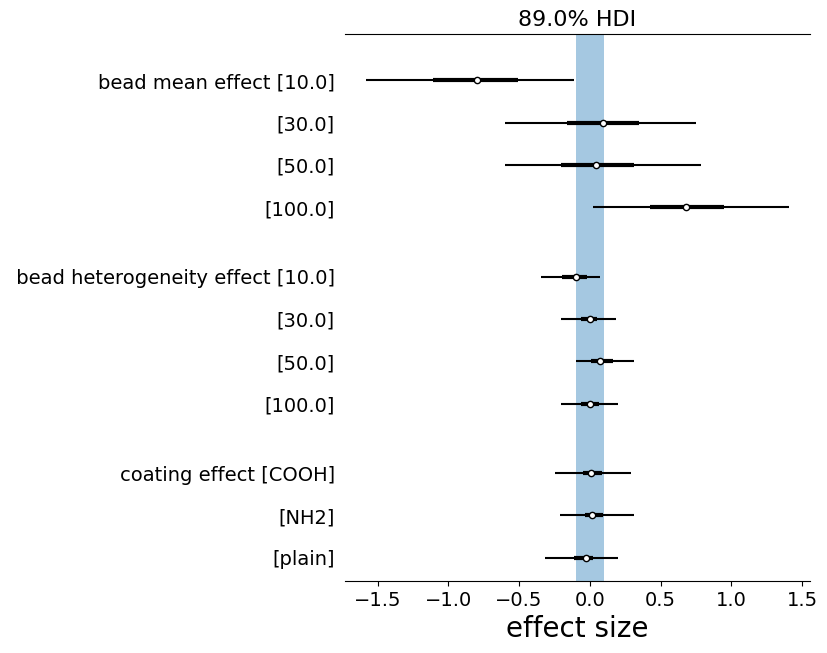

In [ ]:
labeller = azl.MapLabeller(var_name_map={"radius_effect": "bead mean effect ",
                                         "coating_effect": "coating effect ",
                                         "radius_sigma_effect": " bead heterogeneity effect "})

ax = az.plot_forest(trace,var_names=['radius_effect','radius_sigma_effect','coating_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,colors='black')
ax[0].axvspan(-0.1,0.1,alpha=0.4)

ax[0].set_xlabel('effect size',fontsize=20)
fig = ax[0].figure
fig.savefig(f'results/effects_{mec_type}.png',bbox_inches = 'tight',dpi=300)


88.85
100.0
100.0
99.9125


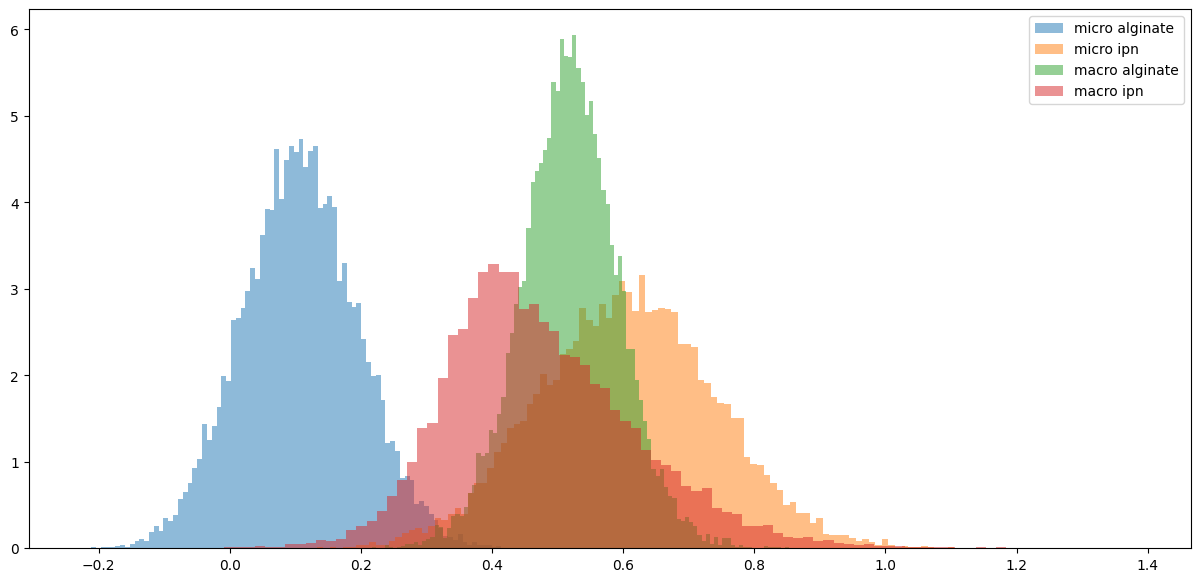

In [ ]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
ee = einops.rearrange(states.slope1, 'i j l -> (i j) l')
fig = plt.figure(figsize=(15,7))
for i,j in zip(range(ee.shape[-1]),names):
    print(np.sum(ee[:,i]>0.0)/ee[:,i].shape[0]*100)
    _ = plt.hist(ee[:,i],bins=100,alpha=0.5,label=j,density=True)
_ = plt.legend()